In [ ]:
import torch, copy
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.nn.functional import cosine_similarity
import os
from sklearn.metrics import roc_auc_score, roc_curve

# Setup

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r /content/drive/MyDrive/PACS /content/PACS


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nickfratto/pacs-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pacs-dataset' dataset.
Path to dataset files: /kaggle/input/pacs-dataset


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))
])

domains = ['art_painting', 'cartoon', 'photo', 'sketch']

domain_datasets = {}
dataloaders = {}

for domain in domains:
  domain_path = f"{path}/pacs_data/pacs_data/{domain}"
  domain_dataset = torchvision.datasets.ImageFolder(domain_path, transform)
  domain_datasets[domain] = domain_dataset
  dataloader = DataLoader(domain_dataset, batch_size=32, shuffle=False, pin_memory=True)
  dataloaders[domain] = dataloader

In [ ]:
#Load the pretrained model and Processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

# Zero-Shot Performance Evaluation

In [ ]:
# define classes and generate prompts
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
prompts = [f"a photo of {c}" for c in classes]

# Generate text Embeddings

with torch.inference_mode():
  text_inputs = processor(text=prompts, return_tensors='pt', padding=True).to(device) #tokenize and return tensors
  text_embeds = model.get_text_features(**text_inputs) #pass tokens to model's text encoder (transformer), returns feature vector for each text prompt
  text_embeds /= text_embeds.norm(dim=-1, keepdim=True) #L2 normalization to measure cosine similarity

In [ ]:
accuracies = {}

with torch.inference_mode():
  for domain in domains:
    correct, total = 0, 0
    for imgs, labels in tqdm(dataloaders[domain]):
      imgs, labels = imgs.to(device), labels.to(device)
      text_embeds = text_embeds.to(device)
      img_embeds = (model.get_image_features(imgs))
      img_embeds /= img_embeds.norm(dim=-1, keepdim=True)
      sim = img_embeds @ text_embeds.T
      preds = sim.argmax(dim=-1)
      correct += (preds == labels).sum().item()
      total += len(labels)
    acc = correct / total
    accuracies[domain] = acc
    print(f"Domain: {domain} | Zero-Shot Accuracy: {(acc*100):.2f}%")

100%|██████████| 64/64 [12:19<00:00, 11.55s/it]


Domain: art_painting | Zero-Shot Accuracy: 95.61%


100%|██████████| 74/74 [14:10<00:00, 11.50s/it]


Domain: cartoon | Zero-Shot Accuracy: 95.90%


100%|██████████| 53/53 [10:03<00:00, 11.39s/it]


Domain: photo | Zero-Shot Accuracy: 99.82%


100%|██████████| 123/123 [21:41<00:00, 10.58s/it]

Domain: sketch | Zero-Shot Accuracy: 84.42%


In [ ]:
print(accuracies)

{'art_painting': 0.9560546875, 'cartoon': 0.9590443686006825, 'photo': 0.9982035928143712, 'sketch': 0.8442351743446169}


# 1. Fine Tuned CLIP Performance Evalutation




In [ ]:
image_embeddings = {}

model.eval()

with torch.inference_mode():
  for domain in tqdm(domains):
    img_embeds, img_labels = [], []
    count = 0
    for imgs, labels in dataloaders[domain]:
      imgs = imgs.to(device, non_blocking=True)
      labels = labels.to(device, non_blocking=True)
      img_embed = model.get_image_features(imgs)
      img_embed /= img_embed.norm(dim=-1, keepdim=True)
      img_embeds.append(img_embed)
      img_labels.append(labels)
      count += 1
    image_embeddings[domain] = (torch.cat(img_embeds), torch.cat(img_labels))

100%|██████████| 4/4 [00:33<00:00,  8.45s/it]


In [ ]:
class LinearClassifier(nn.Module):
  def __init__(self, feature_dim, num_classes):
    super().__init__()

    self.classifier = nn.Linear(feature_dim, num_classes)

  def forward(self, x):
    return self.classifier(x)

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

num_classes = 7
num_epochs = 15

results = {}

for target_domain in domains:
  source_domains = [d for d in domains if d != target_domain]

  X_train = torch.cat([image_embeddings[d][0] for d in source_domains])
  y_train = torch.cat([image_embeddings[d][1] for d in source_domains])
  X_test = image_embeddings[target_domain][0]
  y_test = image_embeddings[target_domain][1]

  X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)

  feature_dim = list(image_embeddings.values())[0][0].shape[1]
  classifier = LinearClassifier(feature_dim, num_classes).to(device)

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

  print('\n-------------------------------------------------------------')
  print(f"Source Domains : {source_domains}")
  print(f"Target Domain: {target_domain}")
  print("\nTraining Linear Classifier on Source Domains: \n")

  for epoch in range(num_epochs):
    classifier.train()
    total_loss, total_correct, total = 0, 0, 0
    for imgs, labels in train_loader:
      optimizer.zero_grad()
      imgs, labels = imgs.to(device), labels.to(device)
      logits = classifier(imgs)
      loss = loss_fn(logits, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      total_correct += (logits.argmax(dim=1) == labels).sum()
      total += len(labels)

    avg_loss = total_loss / len(train_loader)
    acc = (total_correct / total).item()

    print(f"Epoch: {epoch+1} | Loss on Source Data: {avg_loss:.4f} | Accuracy on Source Data: {(acc*100):.2f}%")

  print("\nRunning Inference on Target Domain:")
  classifier.eval()
  with torch.inference_mode():
    total_loss, total_correct, total = 0, 0, 0
    for imgs, labels in test_loader:
      logits = classifier(imgs)
      loss = loss_fn(logits, labels)
      total_loss += loss.item()
      total_correct += (logits.argmax(dim=1) == labels).sum()
      total += len(labels)

    avg_loss = total_loss / len(test_loader)
    acc = (total_correct / total).item()
    results[target_domain] = acc

    print(f"Loss on Target Data: {avg_loss:.4f} | Accuracy on Target Data: {(acc*100):.2f}%")
print("\n=== Summary ===")
for d, acc in results.items():
    print(f"{d}: {acc:.3f}")
print(f"\nMean accuracy: {sum(results.values()) / len(results):.3f}")
print('-------------------------------------------------------------')


-------------------------------------------------------------
Source Domains : ['cartoon', 'photo', 'sketch']
Target Domain: art_painting

Training Linear Classifier on Source Domains: 

Epoch: 1 | Loss on Source Data: 1.5324 | Accuracy on Source Data: 79.68%
Epoch: 2 | Loss on Source Data: 0.9724 | Accuracy on Source Data: 91.20%
Epoch: 3 | Loss on Source Data: 0.6693 | Accuracy on Source Data: 93.69%
Epoch: 4 | Loss on Source Data: 0.5034 | Accuracy on Source Data: 94.23%
Epoch: 5 | Loss on Source Data: 0.4038 | Accuracy on Source Data: 94.54%
Epoch: 6 | Loss on Source Data: 0.3397 | Accuracy on Source Data: 94.71%
Epoch: 7 | Loss on Source Data: 0.2960 | Accuracy on Source Data: 94.75%
Epoch: 8 | Loss on Source Data: 0.2639 | Accuracy on Source Data: 94.86%
Epoch: 9 | Loss on Source Data: 0.2402 | Accuracy on Source Data: 95.03%
Epoch: 10 | Loss on Source Data: 0.2213 | Accuracy on Source Data: 95.13%

Running Inference on Target Domain:
Loss on Target Data: 0.3433 | Accuracy on Ta

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

num_classes = 7
num_epochs = 50

results = {}

for target_domain in domains:
  source_domains = [d for d in domains if d != target_domain]

  X_train = torch.cat([image_embeddings[d][0] for d in source_domains])
  y_train = torch.cat([image_embeddings[d][1] for d in source_domains])
  X_test = image_embeddings[target_domain][0]
  y_test = image_embeddings[target_domain][1]

  X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

  train_dataset = TensorDataset(X_train, y_train)
  test_dataset = TensorDataset(X_test, y_test)

  feature_dim = list(image_embeddings.values())[0][0].shape[1]
  classifier = LinearClassifier(feature_dim, num_classes).to(device)

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

  print('\n-------------------------------------------------------------')
  print(f"Source Domains : {source_domains}")
  print(f"Target Domain: {target_domain}")
  print("\nTraining Linear Classifier on Source Domains: \n")

  for epoch in range(num_epochs):
    classifier.train()
    total_loss, total_correct, total = 0, 0, 0
    for imgs, labels in train_loader:
      optimizer.zero_grad()
      imgs, labels = imgs.to(device), labels.to(device)
      logits = classifier(imgs)
      loss = loss_fn(logits, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      total_correct += (logits.argmax(dim=1) == labels).sum()
      total += len(labels)

    avg_loss = total_loss / len(train_loader)
    acc = (total_correct / total).item()

    print(f"Epoch: {epoch+1} | Loss on Source Data: {avg_loss:.4f} | Accuracy on Source Data: {(acc*100):.2f}%")

  print("\nRunning Inference on Target Domain:")
  classifier.eval()
  with torch.inference_mode():
    total_loss, total_correct, total = 0, 0, 0
    for imgs, labels in test_loader:
      logits = classifier(imgs)
      loss = loss_fn(logits, labels)
      total_loss += loss.item()
      total_correct += (logits.argmax(dim=1) == labels).sum()
      total += len(labels)

    avg_loss = total_loss / len(test_loader)
    acc = (total_correct / total).item()
    results[target_domain] = acc

    print(f"Loss on Target Data: {avg_loss:.4f} | Accuracy on Target Data: {(acc*100):.2f}%")
print("\n=== Summary ===")
for d, acc in results.items():
    print(f"{d}: {acc:.3f}")
print(f"\nMean accuracy: {sum(results.values()) / len(results):.3f}")
print('-------------------------------------------------------------')


-------------------------------------------------------------
Source Domains : ['cartoon', 'photo', 'sketch']
Target Domain: art_painting

Training Linear Classifier on Source Domains: 

Epoch: 1 | Loss on Source Data: 1.5324 | Accuracy on Source Data: 79.68%
Epoch: 2 | Loss on Source Data: 0.9724 | Accuracy on Source Data: 91.20%
Epoch: 3 | Loss on Source Data: 0.6693 | Accuracy on Source Data: 93.69%
Epoch: 4 | Loss on Source Data: 0.5034 | Accuracy on Source Data: 94.23%
Epoch: 5 | Loss on Source Data: 0.4038 | Accuracy on Source Data: 94.54%
Epoch: 6 | Loss on Source Data: 0.3397 | Accuracy on Source Data: 94.71%
Epoch: 7 | Loss on Source Data: 0.2960 | Accuracy on Source Data: 94.75%
Epoch: 8 | Loss on Source Data: 0.2639 | Accuracy on Source Data: 94.86%
Epoch: 9 | Loss on Source Data: 0.2402 | Accuracy on Source Data: 95.03%
Epoch: 10 | Loss on Source Data: 0.2213 | Accuracy on Source Data: 95.13%
Epoch: 11 | Loss on Source Data: 0.2066 | Accuracy on Source Data: 95.20%
Epoch: 

In [ ]:
print(results)

{'art_painting': 0.951171875, 'cartoon': 0.9718429446220398, 'photo': 0.9970059990882874, 'sketch': 0.8424535393714905}


# 2. Prompt Tuning for Domain Adaptation

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

class LearnablePrompts(nn.Module):
  def __init__(self, n_ctx, ctx_dim):
    super().__init__()
    self.prompts = nn.Parameter(
        torch.randn(n_ctx, ctx_dim, device=model.device, requires_grad=True)
        )

def create_text_features(clip_model, processor, classnames, learnable_prompts):
    device = learnable_prompts.prompts.device
    ctx = learnable_prompts.prompts  # (n_ctx, ctx_dim)
    num_classes = len(classnames)
    n_ctx = ctx.size(0)

    # Tokenize normally
    tokens = processor(text=classnames, return_tensors="pt", padding=True, truncation=True).to(device)
    token_embeds = clip_model.text_model.embeddings.token_embedding(tokens.input_ids)

    # Insert learnable prompts after the SOS token
    sos = token_embeds[:, :1, :]
    rest = token_embeds[:, 1:, :]
    prompt_ctx = ctx.unsqueeze(0).expand(num_classes, -1, -1)
    new_embeds = torch.cat([sos, prompt_ctx, rest], dim=1)

    # Adjust positional embeddings
    pos_embeds = clip_model.text_model.embeddings.position_embedding(
        torch.arange(new_embeds.size(1), device=device).unsqueeze(0)
    )
    final_embeds = new_embeds + pos_embeds

    # Adjust attention mask (and convert to bool)
    prompt_mask = torch.ones((num_classes, n_ctx), dtype=torch.bool, device=device)
    attention_mask = torch.cat(
        [tokens.attention_mask[:, :1].bool(), prompt_mask, tokens.attention_mask[:, 1:].bool()],
        dim=1
    )
    attention_mask = attention_mask[:, None, None, :]

    # Run through encoder
    encoder_out = clip_model.text_model.encoder(inputs_embeds=final_embeds, attention_mask=attention_mask)
    hidden = encoder_out.last_hidden_state
    hidden = clip_model.text_model.final_layer_norm(hidden)

    # Use EOS position adjusted for new tokens
    eos_idx = attention_mask.squeeze().sum(dim=1) - 1  # ensures shape [num_classes]
    text_embeds = hidden[torch.arange(num_classes, device=device), eos_idx]
    text_features = clip_model.text_projection(text_embeds)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    return text_features


def source_loss_fn(img_feats, text_feats, labels):
    logits = img_feats @ text_feats.T
    return F.cross_entropy(logits, labels)

def entropy_minimization_loss(logits):
  probs = F.softmax(logits, dim=1)
  entropy = -torch.sum(probs * torch.log(probs + 1e-6), dim=1)
  return entropy.mean()

def target_loss_fn(src_img_feats, tgt_img_feats):
    # Align mean image features between domains
    loss = 1 - F.cosine_similarity(
        src_img_feats.mean(0, keepdim=True),
        tgt_img_feats.mean(0, keepdim=True)
    ).mean()
    return loss


class_names = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

In [ ]:
def train_prompt_tuning(clip_model, processor, source_loader, target_loader, classnames, target_loss_fn=target_loss_fn, source_loss_fn=source_loss_fn,
                        n_ctx=10, ctx_dim=512, epochs=20, lr=1e-3):

    device = next(clip_model.parameters()).device
    learnable_prompts = LearnablePrompts(n_ctx, ctx_dim)
    optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=lr)

    clip_model.eval()
    target_iter = iter(target_loader)

    for epoch in range(epochs):
        learnable_prompts.train()
        total_loss, total_correct, total = 0, 0, 0

        for src_imgs, src_labels in tqdm(source_loader, desc=f"Epoch {epoch+1}/{epochs}"):

            try:
                tgt_imgs, tgt_labels = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                tgt_imgs, tgt_labels = next(target_iter)

            src_imgs, src_labels, tgt_imgs = src_imgs.to(device), src_labels.to(device), tgt_imgs.to(device)
            tgt_labels = tgt_labels.to(device)

            src_img_feats = clip_model.get_image_features(src_imgs)
            src_img_feats = src_img_feats / src_img_feats.norm(dim=-1, keepdim=True)

            tgt_img_feats = clip_model.get_image_features(tgt_imgs)
            tgt_img_feats = tgt_img_feats / tgt_img_feats.norm(dim=-1, keepdim=True)

            text_features = create_text_features(clip_model, processor, classnames, learnable_prompts)

            tgt_logits = tgt_img_feats @ text_features.T
            tgt_preds = tgt_logits.argmax(dim=1)
            total_correct += (tgt_preds==tgt_labels).sum().item()
            total += tgt_labels.size(0)

            src_loss = source_loss_fn(src_img_feats, text_features, src_labels)

            tgt_loss = target_loss_fn(tgt_logits)
            loss = src_loss + 0.3 * tgt_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        tgt_acc = total_correct / total
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(source_loader):.4f} | Target Accuracy: {(tgt_acc*100):.3f}%")

    return learnable_prompts


In [ ]:
def evaluate(clip_model, processor, data_loader, classnames, learnable_prompts):
    device = next(clip_model.parameters()).device
    clip_model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        text_features = create_text_features(clip_model, processor, classnames, learnable_prompts)
        for imgs, labels in tqdm(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            # --- FIXED: compute embeddings before similarity ---
            img_feats = clip_model.get_image_features(imgs)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            # ---------------------------------------------------

            logits = img_feats @ text_features.T
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"\nEvaluation Accuracy on target domain: {acc:.2f}%")
    return acc


In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

source_domain = 'photo'
target_domain = 'sketch'

source_dataset = datasets.ImageFolder(f'/content/PACS/{source_domain}', transform=transform)
target_dataset = datasets.ImageFolder(f'/content/PACS/{target_domain}', transform=transform)

source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True, num_workers=2)

prompts = train_prompt_tuning(
    model, processor,
    source_loader, target_loader,
    classnames=class_names,
)

print(f"\n------- Final Accuracy on Target Domain After Training Prompts --------")
evaluate(model, processor, target_loader, class_names, prompts)

Epoch 1/20: 100%|██████████| 53/53 [00:36<00:00,  1.44it/s]


Epoch [1/20] | Loss: 1.9167 | Target Accuracy: 79.245%


Epoch 2/20: 100%|██████████| 53/53 [00:31<00:00,  1.67it/s]


Epoch [2/20] | Loss: 1.8964 | Target Accuracy: 84.198%


Epoch 3/20: 100%|██████████| 53/53 [00:32<00:00,  1.64it/s]


Epoch [3/20] | Loss: 1.8724 | Target Accuracy: 82.712%


Epoch 4/20: 100%|██████████| 53/53 [00:33<00:00,  1.60it/s]


Epoch [4/20] | Loss: 1.8496 | Target Accuracy: 82.017%


Epoch 5/20: 100%|██████████| 53/53 [00:32<00:00,  1.62it/s]


Epoch [5/20] | Loss: 1.8302 | Target Accuracy: 82.771%


Epoch 6/20: 100%|██████████| 53/53 [00:32<00:00,  1.65it/s]


Epoch [6/20] | Loss: 1.8149 | Target Accuracy: 84.493%


Epoch 7/20: 100%|██████████| 53/53 [00:32<00:00,  1.64it/s]


Epoch [7/20] | Loss: 1.8017 | Target Accuracy: 87.152%


Epoch 8/20: 100%|██████████| 53/53 [00:31<00:00,  1.66it/s]


Epoch [8/20] | Loss: 1.7904 | Target Accuracy: 85.554%


Epoch 9/20: 100%|██████████| 53/53 [00:32<00:00,  1.65it/s]


Epoch [9/20] | Loss: 1.7798 | Target Accuracy: 86.616%


Epoch 10/20: 100%|██████████| 53/53 [00:32<00:00,  1.63it/s]


Epoch [10/20] | Loss: 1.7699 | Target Accuracy: 87.211%


Epoch 11/20: 100%|██████████| 53/53 [00:32<00:00,  1.66it/s]


Epoch [11/20] | Loss: 1.7603 | Target Accuracy: 85.142%


Epoch 12/20: 100%|██████████| 53/53 [00:32<00:00,  1.65it/s]


Epoch [12/20] | Loss: 1.7527 | Target Accuracy: 85.317%


Epoch 13/20: 100%|██████████| 53/53 [00:32<00:00,  1.65it/s]


Epoch [13/20] | Loss: 1.7447 | Target Accuracy: 86.616%


Epoch 14/20: 100%|██████████| 53/53 [00:33<00:00,  1.60it/s]


Epoch [14/20] | Loss: 1.7379 | Target Accuracy: 86.264%


Epoch 15/20: 100%|██████████| 53/53 [00:32<00:00,  1.66it/s]


Epoch [15/20] | Loss: 1.7331 | Target Accuracy: 85.849%


Epoch 16/20: 100%|██████████| 53/53 [00:31<00:00,  1.67it/s]


Epoch [16/20] | Loss: 1.7255 | Target Accuracy: 87.382%


Epoch 17/20: 100%|██████████| 53/53 [00:32<00:00,  1.64it/s]


Epoch [17/20] | Loss: 1.7193 | Target Accuracy: 86.323%


Epoch 18/20: 100%|██████████| 53/53 [00:32<00:00,  1.65it/s]


Epoch [18/20] | Loss: 1.7150 | Target Accuracy: 87.264%


Epoch 19/20: 100%|██████████| 53/53 [00:32<00:00,  1.63it/s]


Epoch [19/20] | Loss: 1.7106 | Target Accuracy: 85.613%


Epoch 20/20: 100%|██████████| 53/53 [00:31<00:00,  1.68it/s]


Epoch [20/20] | Loss: 1.7060 | Target Accuracy: 86.498%

------- Final Accuracy on Target Domain After Training Prompts --------


100%|██████████| 123/123 [00:15<00:00,  7.70it/s]


Evaluation Accuracy on target domain: 86.36%


86.35785187070502

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

source_domain = 'photo'
target_domain = 'sketch'

source_dataset = datasets.ImageFolder(f'{path}/pacs_data/pacs_data/{source_domain}', transform=transform)
target_dataset = datasets.ImageFolder(f'{path}/pacs_data/pacs_data/{target_domain}', transform=transform)

source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True, num_workers=2)

prompts = train_prompt_tuning(
    model, processor,
    source_loader, target_loader,
    classnames=class_names,
    target_loss_fn=entropy_minimization_loss
)

print(f"\n------- Final Accuracy on Target Domain After Training Prompts --------")
evaluate(model, processor, target_loader, class_names, prompts)

Epoch 1/20: 100%|██████████| 53/53 [00:30<00:00,  1.74it/s]


Epoch [1/20] | Loss: 2.4634 | Target Accuracy: 85.318%


Epoch 2/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [2/20] | Loss: 2.4314 | Target Accuracy: 85.024%


Epoch 3/20: 100%|██████████| 53/53 [00:29<00:00,  1.77it/s]


Epoch [3/20] | Loss: 2.4059 | Target Accuracy: 85.317%


Epoch 4/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [4/20] | Loss: 2.3848 | Target Accuracy: 84.080%


Epoch 5/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [5/20] | Loss: 2.3671 | Target Accuracy: 83.541%


Epoch 6/20: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]


Epoch [6/20] | Loss: 2.3527 | Target Accuracy: 84.788%


Epoch 7/20: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]


Epoch [7/20] | Loss: 2.3400 | Target Accuracy: 86.619%


Epoch 8/20: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]


Epoch [8/20] | Loss: 2.3296 | Target Accuracy: 85.024%


Epoch 9/20: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]


Epoch [9/20] | Loss: 2.3200 | Target Accuracy: 86.026%


Epoch 10/20: 100%|██████████| 53/53 [00:30<00:00,  1.77it/s]


Epoch [10/20] | Loss: 2.3115 | Target Accuracy: 85.080%


Epoch 11/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [11/20] | Loss: 2.3037 | Target Accuracy: 84.965%


Epoch 12/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [12/20] | Loss: 2.2960 | Target Accuracy: 85.790%


Epoch 13/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [13/20] | Loss: 2.2894 | Target Accuracy: 83.667%


Epoch 14/20: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]


Epoch [14/20] | Loss: 2.2827 | Target Accuracy: 85.317%


Epoch 15/20: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]


Epoch [15/20] | Loss: 2.2779 | Target Accuracy: 84.965%


Epoch 16/20: 100%|██████████| 53/53 [00:30<00:00,  1.76it/s]


Epoch [16/20] | Loss: 2.2714 | Target Accuracy: 83.432%


Epoch 17/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [17/20] | Loss: 2.2662 | Target Accuracy: 83.185%


Epoch 18/20: 100%|██████████| 53/53 [00:30<00:00,  1.74it/s]


Epoch [18/20] | Loss: 2.2615 | Target Accuracy: 84.080%


Epoch 19/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [19/20] | Loss: 2.2572 | Target Accuracy: 83.008%


Epoch 20/20: 100%|██████████| 53/53 [00:30<00:00,  1.75it/s]


Epoch [20/20] | Loss: 2.2528 | Target Accuracy: 83.196%

------- Final Accuracy on Target Domain After Training Prompts --------


100%|██████████| 123/123 [00:14<00:00,  8.54it/s]


Evaluation Accuracy on target domain: 83.13%


83.12547722066684

# 3. Gradient Conflict

In [ ]:
class LearnablePrompts(nn.Module):
  def __init__(self, domains, dom_ag=10, dom_sp=10, ctx_dim=512):
    super().__init__()
    self.dom_ag_ctx = nn.Parameter(torch.randn(dom_ag, ctx_dim), requires_grad=True)
    self.dom_sp_ctx = nn.ParameterDict({
          d: nn.Parameter(torch.randn(dom_sp, ctx_dim), requires_grad=True)
          for d in domains
        })
  def get_ctx(self, domain):
    return torch.cat([self.dom_ag_ctx, self.dom_sp_ctx[domain]], dim=0)


def create_text_features(clip_model, processor, classnames, learnable_prompts, domain):
    ctx = learnable_prompts.get_ctx(domain)  # (n_ctx, ctx_dim)
    num_classes = len(classnames)
    n_ctx = ctx.size(0)

    # Tokenize normally
    tokens = processor(text=classnames, return_tensors="pt", padding=True, truncation=True).to(device)
    token_embeds = clip_model.text_model.embeddings.token_embedding(tokens.input_ids)

    # Insert learnable prompts after the SOS token
    sos = token_embeds[:, :1, :]
    rest = token_embeds[:, 1:, :]
    prompt_ctx = ctx.unsqueeze(0).expand(num_classes, -1, -1)
    new_embeds = torch.cat([sos, prompt_ctx, rest], dim=1)

    # Adjust positional embeddings
    pos_embeds = clip_model.text_model.embeddings.position_embedding(
        torch.arange(new_embeds.size(1), device=device).unsqueeze(0)
    )
    final_embeds = new_embeds + pos_embeds

    # Adjust attention mask (and convert to bool)
    prompt_mask = torch.ones((num_classes, n_ctx), dtype=torch.bool, device=device)
    attention_mask = torch.cat(
        [tokens.attention_mask[:, :1].bool(), prompt_mask, tokens.attention_mask[:, 1:].bool()],
        dim=1
    )
    attention_mask = attention_mask[:, None, None, :]

    # Run through encoder
    encoder_out = clip_model.text_model.encoder(inputs_embeds=final_embeds, attention_mask=attention_mask)
    hidden = encoder_out.last_hidden_state
    hidden = clip_model.text_model.final_layer_norm(hidden)

    # Use EOS position adjusted for new tokens
    eos_idx = attention_mask.squeeze().sum(dim=1) - 1  # ensures shape [num_classes]
    text_embeds = hidden[torch.arange(num_classes, device=device), eos_idx]
    text_features = clip_model.text_projection(text_embeds)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    return text_features

source_domain = 'photo'
target_domain = 'sketch'
domains = [source_domain, target_domain]
class_names = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
source_dataset = datasets.ImageFolder(f"{path}/pacs_data/pacs_data/{source_domain}", transform=transform)
target_dataset = datasets.ImageFolder(f"{path}/pacs_data/pacs_data/{target_domain}", transform=transform)
source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)
learnable_prompts = LearnablePrompts(domains).to(device)

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

def get_flat_grads(model, only_ag=True):
    grads = []
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        if only_ag and "dom_ag_ctx" not in name:
            continue  # skip domain-specific grads
        grads.append(p.grad.view(-1))
    return torch.cat(grads) if grads else torch.tensor([], device=device)


epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=1e-3)

logs = {
    "epoch_loss": [],
    "src_acc": [],
    "tgt_acc": [],
    "grad_conflict": [],
}

print('-----------------------------------------------------------------')
print(f"Training Learnable Prompts on Source Domains\n")

for epoch in tqdm(range(epochs)):
    epoch_loss, src_total_loss, tgt_total_loss = 0.0, 0.0, 0.0
    src_correct, tgt_correct = 0, 0
    src_total, tgt_total = 0, 0
    grad_conflicts = []

    for (src_imgs, src_labels), (tgt_imgs, tgt_labels) in zip(source_loader, target_loader):

        optimizer.zero_grad()

        # ----- SOURCE -----
        src_imgs, src_labels = src_imgs.to(device), src_labels.to(device)
        src_img_feats = model.get_image_features(src_imgs)
        src_img_feats = src_img_feats / src_img_feats.norm(dim=-1, keepdim=True)
        src_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, source_domain)
        src_txt_feats = src_txt_feats / src_txt_feats.norm(dim=-1, keepdim=True)
        src_sim = src_img_feats @ src_txt_feats.T
        src_preds = src_sim.argmax(dim=1)
        src_correct += (src_preds == src_labels).sum().item()
        src_total += src_labels.size(0)
        src_loss = loss_fn(src_sim, src_labels)

        src_loss.backward(retain_graph=True)
        src_grd = get_flat_grads(learnable_prompts).detach().clone()

        # ----- TARGET -----
        tgt_imgs, tgt_labels = tgt_imgs.to(device), tgt_labels.to(device)
        tgt_img_feats = model.get_image_features(tgt_imgs)
        tgt_img_feats = tgt_img_feats / tgt_img_feats.norm(dim=-1, keepdim=True)
        tgt_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, target_domain)
        tgt_txt_feats = tgt_txt_feats / tgt_txt_feats.norm(dim=-1, keepdim=True)
        tgt_sim = tgt_img_feats @ tgt_txt_feats.T
        tgt_preds = tgt_sim.argmax(dim=1)
        tgt_correct += (tgt_preds == tgt_labels).sum().item()
        tgt_total += tgt_labels.size(0)
        tgt_loss = loss_fn(tgt_sim, tgt_labels)

        tgt_loss.backward(retain_graph=True)
        tgt_grd = get_flat_grads(learnable_prompts).detach().clone()

        # --- Gradient conflict ---
        if len(src_grd) > 0 and len(tgt_grd) > 0:
            conflict = F.cosine_similarity(src_grd.unsqueeze(0), tgt_grd.unsqueeze(0)).item()
            grad_conflicts.append(conflict)
        else:
            grad_conflicts.append(0.0)

        # --- Total loss & optimization ---
        total_loss = src_loss + tgt_loss
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        src_total_loss += src_loss.item()
        tgt_total_loss += tgt_loss.item()

    # --- Epoch averages ---
    src_avg_loss = src_total_loss / len(source_loader)
    tgt_avg_loss = tgt_total_loss / len(source_loader)
    avg_loss = epoch_loss / len(source_loader)
    src_acc = src_correct / src_total if src_total > 0 else 0
    tgt_acc = tgt_correct / tgt_total if tgt_total > 0 else 0
    avg_conflict = sum(grad_conflicts) / len(grad_conflicts)

    # --- Logging ---
    logs["epoch_loss"].append(avg_loss)
    logs["src_acc"].append(src_acc)
    logs["tgt_acc"].append(tgt_acc)
    logs["grad_conflict"].append(avg_conflict)

    print(f"\nEpoch {epoch+1}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Source Loss: {src_avg_loss:.4f}")
    print(f"  Target Loss: {tgt_avg_loss:.4f}")
    print(f"  Source Accuracy: {src_acc*100:.2f}%")
    print(f"  Target Accuracy: {tgt_acc*100:.2f}%")
    print(f"  Avg Gradient Cosine Similarity: {avg_conflict:.4f}")

print('\n-----------------------------------------------------------------\n')

# Save logs for later plotting
import json
with open("training_logs.json", "w") as f:
    json.dump(logs, f, indent=2)

-----------------------------------------------------------------
Training Learnable Prompts on Source Domains



 10%|█         | 1/10 [01:01<09:13, 61.50s/it]


Epoch 1:
  Total Loss: 3.8290
  Source Accuracy: 82.16%
  Target Accuracy: 74.59%
  Avg Gradient Cosine Similarity: 0.9345


 20%|██        | 2/10 [02:01<08:05, 60.71s/it]


Epoch 2:
  Total Loss: 3.7630
  Source Accuracy: 99.58%
  Target Accuracy: 83.37%
  Avg Gradient Cosine Similarity: 0.8795


 30%|███       | 3/10 [03:01<07:02, 60.39s/it]


Epoch 3:
  Total Loss: 3.6961
  Source Accuracy: 99.64%
  Target Accuracy: 81.31%
  Avg Gradient Cosine Similarity: 0.8566


 40%|████      | 4/10 [04:01<06:01, 60.28s/it]


Epoch 4:
  Total Loss: 3.6440
  Source Accuracy: 99.70%
  Target Accuracy: 79.95%
  Avg Gradient Cosine Similarity: 0.7991


 50%|█████     | 5/10 [05:01<05:01, 60.23s/it]


Epoch 5:
  Total Loss: 3.6002
  Source Accuracy: 99.70%
  Target Accuracy: 79.89%
  Avg Gradient Cosine Similarity: 0.8208


 60%|██████    | 6/10 [06:02<04:01, 60.28s/it]


Epoch 6:
  Total Loss: 3.5582
  Source Accuracy: 99.70%
  Target Accuracy: 78.66%
  Avg Gradient Cosine Similarity: 0.8004


 70%|███████   | 7/10 [07:02<03:00, 60.20s/it]


Epoch 7:
  Total Loss: 3.5248
  Source Accuracy: 99.70%
  Target Accuracy: 77.65%
  Avg Gradient Cosine Similarity: 0.7546


 80%|████████  | 8/10 [08:02<02:00, 60.24s/it]


Epoch 8:
  Total Loss: 3.4930
  Source Accuracy: 99.58%
  Target Accuracy: 74.53%
  Avg Gradient Cosine Similarity: 0.7998


 90%|█████████ | 9/10 [09:02<01:00, 60.16s/it]


Epoch 9:
  Total Loss: 3.4706
  Source Accuracy: 99.58%
  Target Accuracy: 72.46%
  Avg Gradient Cosine Similarity: 0.8169


100%|██████████| 10/10 [10:02<00:00, 60.28s/it]


Epoch 10:
  Total Loss: 3.4416
  Source Accuracy: 99.52%
  Target Accuracy: 71.93%
  Avg Gradient Cosine Similarity: 0.8475

-----------------------------------------------------------------



In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

def get_flat_grads(model, only_ag=True):
    grads = []
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        if only_ag and "dom_ag_ctx" not in name:
            continue  # skip domain-specific grads
        grads.append(p.grad.view(-1))
    return torch.cat(grads) if grads else torch.tensor([], device=device)


epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=1e-3)

logs = {
    "epoch_loss": [],
    "src_acc": [],
    "tgt_acc": [],
    "grad_conflict": [],
}

print('-----------------------------------------------------------------')
print(f"Training Learnable Prompts on Source Domains\n")

for epoch in tqdm(range(epochs)):
    epoch_loss, src_total_loss, tgt_total_loss = 0.0, 0.0, 0.0
    src_correct, tgt_correct = 0, 0
    src_total, tgt_total = 0, 0
    grad_conflicts = []

    for (src_imgs, src_labels), (tgt_imgs, tgt_labels) in zip(source_loader, target_loader):

        optimizer.zero_grad()

        # ----- SOURCE -----
        src_imgs, src_labels = src_imgs.to(device), src_labels.to(device)
        src_img_feats = model.get_image_features(src_imgs)
        src_img_feats = src_img_feats / src_img_feats.norm(dim=-1, keepdim=True)
        src_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, source_domain)
        src_txt_feats = src_txt_feats / src_txt_feats.norm(dim=-1, keepdim=True)
        src_sim = src_img_feats @ src_txt_feats.T
        src_preds = src_sim.argmax(dim=1)
        src_correct += (src_preds == src_labels).sum().item()
        src_total += src_labels.size(0)
        src_loss = loss_fn(src_sim, src_labels)

        src_loss.backward(retain_graph=True)
        src_grd = get_flat_grads(learnable_prompts).detach().clone()

        # ----- TARGET -----
        tgt_imgs, tgt_labels = tgt_imgs.to(device), tgt_labels.to(device)
        tgt_img_feats = model.get_image_features(tgt_imgs)
        tgt_img_feats = tgt_img_feats / tgt_img_feats.norm(dim=-1, keepdim=True)
        tgt_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, target_domain)
        tgt_txt_feats = tgt_txt_feats / tgt_txt_feats.norm(dim=-1, keepdim=True)
        tgt_sim = tgt_img_feats @ tgt_txt_feats.T
        tgt_preds = tgt_sim.argmax(dim=1)
        tgt_correct += (tgt_preds == tgt_labels).sum().item()
        tgt_total += tgt_labels.size(0)
        tgt_loss = loss_fn(tgt_sim, tgt_labels)

        tgt_loss.backward(retain_graph=True)
        tgt_grd = get_flat_grads(learnable_prompts).detach().clone()

        # --- Gradient conflict ---
        if len(src_grd) > 0 and len(tgt_grd) > 0:
            conflict = F.cosine_similarity(src_grd.unsqueeze(0), tgt_grd.unsqueeze(0)).item()
            grad_conflicts.append(conflict)
        else:
            grad_conflicts.append(0.0)

        # --- Total loss & optimization ---
        total_loss = src_loss + tgt_loss
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        src_total_loss += src_loss.item()
        tgt_total_loss += tgt_loss.item()

    # --- Epoch averages ---
    src_avg_loss = src_total_loss / len(source_loader)
    tgt_avg_loss = tgt_total_loss / len(source_loader)
    avg_loss = epoch_loss / len(source_loader)
    src_acc = src_correct / src_total if src_total > 0 else 0
    tgt_acc = tgt_correct / tgt_total if tgt_total > 0 else 0
    avg_conflict = sum(grad_conflicts) / len(grad_conflicts)

    # --- Logging ---
    logs["epoch_loss"].append(avg_loss)
    logs["src_acc"].append(src_acc)
    logs["tgt_acc"].append(tgt_acc)
    logs["grad_conflict"].append(avg_conflict)

    print(f"\nEpoch {epoch+1}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Source Loss: {src_avg_loss:.4f}")
    print(f"  Target Loss: {tgt_avg_loss:.4f}")
    print(f"  Source Accuracy: {src_acc*100:.2f}%")
    print(f"  Target Accuracy: {tgt_acc*100:.2f}%")
    print(f"  Avg Gradient Cosine Similarity: {avg_conflict:.4f}")

print('\n-----------------------------------------------------------------\n')


-----------------------------------------------------------------
Training Learnable Prompts on Source Domains



 10%|█         | 1/10 [01:12<10:56, 72.94s/it]


Epoch 1:
  Total Loss: 3.8329
  Source Loss: 1.9046
  Target Loss: 1.9283
  Source Accuracy: 93.05%
  Target Accuracy: 77.95%
  Avg Gradient Cosine Similarity: 0.9222


 20%|██        | 2/10 [02:17<09:01, 67.73s/it]


Epoch 2:
  Total Loss: 3.7699
  Source Loss: 1.8688
  Target Loss: 1.9010
  Source Accuracy: 98.74%
  Target Accuracy: 79.72%
  Avg Gradient Cosine Similarity: 0.8405


 30%|███       | 3/10 [03:17<07:31, 64.44s/it]


Epoch 3:
  Total Loss: 3.6993
  Source Loss: 1.8318
  Target Loss: 1.8676
  Source Accuracy: 99.34%
  Target Accuracy: 76.00%
  Avg Gradient Cosine Similarity: 0.7694


 40%|████      | 4/10 [04:20<06:22, 63.76s/it]


Epoch 4:
  Total Loss: 3.6402
  Source Loss: 1.8031
  Target Loss: 1.8371
  Source Accuracy: 99.40%
  Target Accuracy: 69.46%
  Avg Gradient Cosine Similarity: 0.6971


 50%|█████     | 5/10 [05:19<05:11, 62.24s/it]


Epoch 5:
  Total Loss: 3.5910
  Source Loss: 1.7808
  Target Loss: 1.8102
  Source Accuracy: 99.40%
  Target Accuracy: 67.57%
  Avg Gradient Cosine Similarity: 0.6607


 60%|██████    | 6/10 [06:18<04:04, 61.15s/it]


Epoch 6:
  Total Loss: 3.5493
  Source Loss: 1.7620
  Target Loss: 1.7874
  Source Accuracy: 99.40%
  Target Accuracy: 68.51%
  Avg Gradient Cosine Similarity: 0.6446


 70%|███████   | 7/10 [07:17<03:01, 60.44s/it]


Epoch 7:
  Total Loss: 3.5217
  Source Loss: 1.7457
  Target Loss: 1.7761
  Source Accuracy: 99.34%
  Target Accuracy: 68.75%
  Avg Gradient Cosine Similarity: 0.6333


 80%|████████  | 8/10 [08:16<01:59, 59.95s/it]


Epoch 8:
  Total Loss: 3.4928
  Source Loss: 1.7297
  Target Loss: 1.7630
  Source Accuracy: 99.28%
  Target Accuracy: 66.98%
  Avg Gradient Cosine Similarity: 0.6870


 90%|█████████ | 9/10 [09:15<00:59, 59.62s/it]


Epoch 9:
  Total Loss: 3.4728
  Source Loss: 1.7161
  Target Loss: 1.7567
  Source Accuracy: 99.16%
  Target Accuracy: 65.74%
  Avg Gradient Cosine Similarity: 0.7161


100%|██████████| 10/10 [10:14<00:00, 61.45s/it]


Epoch 10:
  Total Loss: 3.4434
  Source Loss: 1.7030
  Target Loss: 1.7403
  Source Accuracy: 98.98%
  Target Accuracy: 66.33%
  Avg Gradient Cosine Similarity: 0.7029

-----------------------------------------------------------------



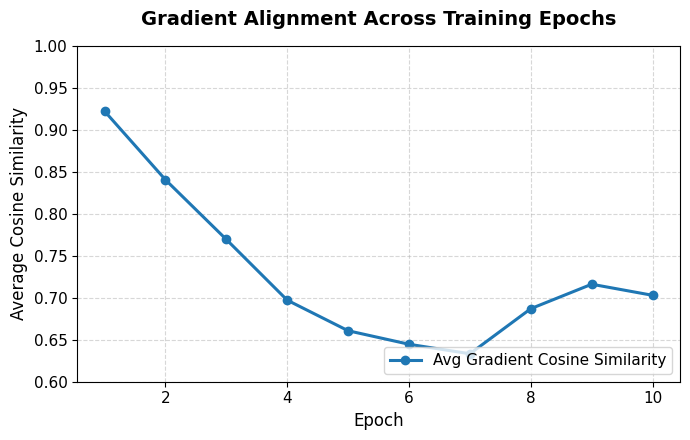

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 11))
cosine_similarity = [0.9222, 0.8405, 0.7694, 0.6971, 0.6607, 0.6446, 0.6333, 0.6870, 0.7161, 0.7029]

# Plot
plt.figure(figsize=(7, 4.5))
plt.plot(epochs, cosine_similarity, marker='o', linewidth=2.2, markersize=6, color='tab:blue', label='Avg Gradient Cosine Similarity')

# Style
plt.title("Gradient Alignment Across Training Epochs", fontsize=14, fontweight='semibold', pad=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Average Cosine Similarity", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0.6, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11, loc='lower right')
plt.tight_layout()

# Show
plt.show()

In [ ]:
source_domain = 'photo'
target_domain = 'art_painting'
domains = [source_domain, target_domain]
class_names = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
source_dataset = datasets.ImageFolder(f"{path}/pacs_data/pacs_data/{source_domain}", transform=transform)
target_dataset = datasets.ImageFolder(f"{path}/pacs_data/pacs_data/{target_domain}", transform=transform)
source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)
learnable_prompts = LearnablePrompts(domains).to(device)

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

def get_flat_grads(model, only_ag=True):
    grads = []
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        if only_ag and "dom_ag_ctx" not in name:
            continue  # skip domain-specific grads
        grads.append(p.grad.view(-1))
    return torch.cat(grads) if grads else torch.tensor([], device=device)


epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=1e-3)

logs = {
    "epoch_loss": [],
    "src_acc": [],
    "tgt_acc": [],
    "grad_conflict": [],
}

print('-----------------------------------------------------------------')
print(f"Training Learnable Prompts on Source Domains\n")

for epoch in tqdm(range(epochs)):
    epoch_loss, src_total_loss, tgt_total_loss = 0.0, 0.0, 0.0
    src_correct, tgt_correct = 0, 0
    src_total, tgt_total = 0, 0
    grad_conflicts = []

    for (src_imgs, src_labels), (tgt_imgs, tgt_labels) in zip(source_loader, target_loader):

        optimizer.zero_grad()

        # ----- SOURCE -----
        src_imgs, src_labels = src_imgs.to(device), src_labels.to(device)
        src_img_feats = model.get_image_features(src_imgs)
        src_img_feats = src_img_feats / src_img_feats.norm(dim=-1, keepdim=True)
        src_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, source_domain)
        src_txt_feats = src_txt_feats / src_txt_feats.norm(dim=-1, keepdim=True)
        src_sim = src_img_feats @ src_txt_feats.T
        src_preds = src_sim.argmax(dim=1)
        src_correct += (src_preds == src_labels).sum().item()
        src_total += src_labels.size(0)
        src_loss = loss_fn(src_sim, src_labels)

        src_loss.backward(retain_graph=True)
        src_grd = get_flat_grads(learnable_prompts).detach().clone()

        # ----- TARGET -----
        tgt_imgs, tgt_labels = tgt_imgs.to(device), tgt_labels.to(device)
        tgt_img_feats = model.get_image_features(tgt_imgs)
        tgt_img_feats = tgt_img_feats / tgt_img_feats.norm(dim=-1, keepdim=True)
        tgt_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, target_domain)
        tgt_txt_feats = tgt_txt_feats / tgt_txt_feats.norm(dim=-1, keepdim=True)
        tgt_sim = tgt_img_feats @ tgt_txt_feats.T
        tgt_preds = tgt_sim.argmax(dim=1)
        tgt_correct += (tgt_preds == tgt_labels).sum().item()
        tgt_total += tgt_labels.size(0)
        tgt_loss = loss_fn(tgt_sim, tgt_labels)

        tgt_loss.backward(retain_graph=True)
        tgt_grd = get_flat_grads(learnable_prompts).detach().clone()

        # --- Gradient conflict ---
        if len(src_grd) > 0 and len(tgt_grd) > 0:
            conflict = F.cosine_similarity(src_grd.unsqueeze(0), tgt_grd.unsqueeze(0)).item()
            grad_conflicts.append(conflict)
        else:
            grad_conflicts.append(0.0)

        # --- Total loss & optimization ---
        total_loss = src_loss + tgt_loss
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        src_total_loss += src_loss.item()
        tgt_total_loss += tgt_loss.item()

    # --- Epoch averages ---
    src_avg_loss = src_total_loss / len(source_loader)
    tgt_avg_loss = tgt_total_loss / len(source_loader)
    avg_loss = epoch_loss / len(source_loader)
    src_acc = src_correct / src_total if src_total > 0 else 0
    tgt_acc = tgt_correct / tgt_total if tgt_total > 0 else 0
    avg_conflict = sum(grad_conflicts) / len(grad_conflicts)

    # --- Logging ---
    logs["epoch_loss"].append(avg_loss)
    logs["src_acc"].append(src_acc)
    logs["tgt_acc"].append(tgt_acc)
    logs["grad_conflict"].append(avg_conflict)

    print(f"\nEpoch {epoch+1}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Source Loss: {src_avg_loss:.4f}")
    print(f"  Target Loss: {tgt_avg_loss:.4f}")
    print(f"  Source Accuracy: {src_acc*100:.2f}%")
    print(f"  Target Accuracy: {tgt_acc*100:.2f}%")
    print(f"  Avg Gradient Cosine Similarity: {avg_conflict:.4f}")

print('\n-----------------------------------------------------------------\n')

-----------------------------------------------------------------
Training Learnable Prompts on Source Domains



 10%|█         | 1/10 [01:04<09:40, 64.51s/it]


Epoch 1:
  Total Loss: 3.8260
  Source Loss: 1.9080
  Target Loss: 1.9181
  Source Accuracy: 95.27%
  Target Accuracy: 80.66%
  Avg Gradient Cosine Similarity: 0.9014


 20%|██        | 2/10 [02:04<08:14, 61.75s/it]


Epoch 2:
  Total Loss: 3.7692
  Source Loss: 1.8783
  Target Loss: 1.8909
  Source Accuracy: 99.64%
  Target Accuracy: 93.34%
  Avg Gradient Cosine Similarity: 0.8109


 30%|███       | 3/10 [03:03<07:03, 60.50s/it]


Epoch 3:
  Total Loss: 3.7072
  Source Loss: 1.8434
  Target Loss: 1.8638
  Source Accuracy: 99.76%
  Target Accuracy: 95.93%
  Avg Gradient Cosine Similarity: 0.8322


 40%|████      | 4/10 [04:02<05:59, 59.87s/it]


Epoch 4:
  Total Loss: 3.6550
  Source Loss: 1.8107
  Target Loss: 1.8443
  Source Accuracy: 99.76%
  Target Accuracy: 96.52%
  Avg Gradient Cosine Similarity: 0.8078


 50%|█████     | 5/10 [05:01<04:57, 59.56s/it]


Epoch 5:
  Total Loss: 3.6113
  Source Loss: 1.7827
  Target Loss: 1.8286
  Source Accuracy: 99.76%
  Target Accuracy: 96.64%
  Avg Gradient Cosine Similarity: 0.7696


 60%|██████    | 6/10 [06:00<03:57, 59.35s/it]


Epoch 6:
  Total Loss: 3.5758
  Source Loss: 1.7598
  Target Loss: 1.8161
  Source Accuracy: 99.82%
  Target Accuracy: 96.82%
  Avg Gradient Cosine Similarity: 0.7418


 70%|███████   | 7/10 [06:58<02:57, 59.17s/it]


Epoch 7:
  Total Loss: 3.5451
  Source Loss: 1.7403
  Target Loss: 1.8048
  Source Accuracy: 99.82%
  Target Accuracy: 96.70%
  Avg Gradient Cosine Similarity: 0.7452


 80%|████████  | 8/10 [07:58<01:58, 59.16s/it]


Epoch 8:
  Total Loss: 3.5180
  Source Loss: 1.7228
  Target Loss: 1.7953
  Source Accuracy: 99.88%
  Target Accuracy: 96.05%
  Avg Gradient Cosine Similarity: 0.7290


 90%|█████████ | 9/10 [08:56<00:59, 59.02s/it]


Epoch 9:
  Total Loss: 3.4949
  Source Loss: 1.7088
  Target Loss: 1.7860
  Source Accuracy: 99.58%
  Target Accuracy: 95.64%
  Avg Gradient Cosine Similarity: 0.7277


100%|██████████| 10/10 [09:55<00:00, 59.57s/it]


Epoch 10:
  Total Loss: 3.4748
  Source Loss: 1.6958
  Target Loss: 1.7790
  Source Accuracy: 99.64%
  Target Accuracy: 95.46%
  Avg Gradient Cosine Similarity: 0.7269

-----------------------------------------------------------------



In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

def get_flat_grads(model, only_ag=True):
    grads = []
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        if only_ag and "dom_ag_ctx" not in name:
            continue  # skip domain-specific grads
        grads.append(p.grad.view(-1))
    return torch.cat(grads) if grads else torch.tensor([], device=device)


epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=1e-3)

logs = {
    "epoch_loss": [],
    "src_acc": [],
    "tgt_acc": [],
    "grad_conflict": [],
}

print('-----------------------------------------------------------------')
print(f"Training Learnable Prompts on Source Domains\n")

for epoch in tqdm(range(epochs)):
    epoch_loss, src_total_loss, tgt_total_loss = 0.0, 0.0, 0.0
    src_correct, tgt_correct = 0, 0
    src_total, tgt_total = 0, 0
    grad_conflicts = []

    for (src_imgs, src_labels), (tgt_imgs, tgt_labels) in zip(source_loader, target_loader):

        optimizer.zero_grad()

        # ----- SOURCE -----
        src_imgs, src_labels = src_imgs.to(device), src_labels.to(device)
        src_img_feats = model.get_image_features(src_imgs)
        src_img_feats = src_img_feats / src_img_feats.norm(dim=-1, keepdim=True)
        src_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, source_domain)
        src_txt_feats = src_txt_feats / src_txt_feats.norm(dim=-1, keepdim=True)
        src_sim = src_img_feats @ src_txt_feats.T
        src_preds = src_sim.argmax(dim=1)
        src_correct += (src_preds == src_labels).sum().item()
        src_total += src_labels.size(0)
        src_loss = loss_fn(src_sim, src_labels)

        src_loss.backward(retain_graph=True)
        src_grd = get_flat_grads(learnable_prompts).detach().clone()

        # ----- TARGET -----
        tgt_imgs, tgt_labels = tgt_imgs.to(device), tgt_labels.to(device)
        tgt_img_feats = model.get_image_features(tgt_imgs)
        tgt_img_feats = tgt_img_feats / tgt_img_feats.norm(dim=-1, keepdim=True)
        tgt_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, target_domain)
        tgt_txt_feats = tgt_txt_feats / tgt_txt_feats.norm(dim=-1, keepdim=True)
        tgt_sim = tgt_img_feats @ tgt_txt_feats.T
        tgt_preds = tgt_sim.argmax(dim=1)
        tgt_correct += (tgt_preds == tgt_labels).sum().item()
        tgt_total += tgt_labels.size(0)
        tgt_loss = loss_fn(tgt_sim, tgt_labels)

        tgt_loss.backward(retain_graph=True)
        tgt_grd = get_flat_grads(learnable_prompts).detach().clone()

        # --- Gradient conflict ---
        if len(src_grd) > 0 and len(tgt_grd) > 0:
            conflict = F.cosine_similarity(src_grd.unsqueeze(0), tgt_grd.unsqueeze(0)).item()
            grad_conflicts.append(conflict)
        else:
            grad_conflicts.append(0.0)

        # --- Total loss & optimization ---
        align_loss = 1 - F.cosine_similarity(src_grd.unsqueeze(0), tgt_grd.unsqueeze(0)).mean()
        total_loss = src_loss + tgt_loss + 0.01 * align_loss
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        src_total_loss += src_loss.item()
        tgt_total_loss += tgt_loss.item()

    # --- Epoch averages ---
    src_avg_loss = src_total_loss / len(source_loader)
    tgt_avg_loss = tgt_total_loss / len(source_loader)
    avg_loss = epoch_loss / len(source_loader)
    src_acc = src_correct / src_total if src_total > 0 else 0
    tgt_acc = tgt_correct / tgt_total if tgt_total > 0 else 0
    avg_conflict = sum(grad_conflicts) / len(grad_conflicts)

    # --- Logging ---
    logs["epoch_loss"].append(avg_loss)
    logs["src_acc"].append(src_acc)
    logs["tgt_acc"].append(tgt_acc)
    logs["grad_conflict"].append(avg_conflict)

    print(f"\nEpoch {epoch+1}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Source Loss: {src_avg_loss:.4f}")
    print(f"  Target Loss: {tgt_avg_loss:.4f}")
    print(f"  Source Accuracy: {src_acc*100:.2f}%")
    print(f"  Target Accuracy: {tgt_acc*100:.2f}%")
    print(f"  Avg Gradient Cosine Similarity: {avg_conflict:.4f}")

print('\n-----------------------------------------------------------------\n')

-----------------------------------------------------------------
Training Learnable Prompts on Source Domains



 10%|█         | 1/10 [01:01<09:15, 61.76s/it]


Epoch 1:
  Total Loss: 3.8213
  Source Loss: 1.9080
  Target Loss: 1.9121
  Source Accuracy: 95.09%
  Target Accuracy: 80.90%
  Avg Gradient Cosine Similarity: 0.8904


 20%|██        | 2/10 [02:00<07:59, 59.98s/it]


Epoch 2:
  Total Loss: 3.7669
  Source Loss: 1.8786
  Target Loss: 1.8867
  Source Accuracy: 99.52%
  Target Accuracy: 85.44%
  Avg Gradient Cosine Similarity: 0.8398


 30%|███       | 3/10 [02:59<06:55, 59.40s/it]


Epoch 3:
  Total Loss: 3.7037
  Source Loss: 1.8440
  Target Loss: 1.8578
  Source Accuracy: 99.82%
  Target Accuracy: 85.20%
  Avg Gradient Cosine Similarity: 0.8078


 40%|████      | 4/10 [03:58<05:54, 59.16s/it]


Epoch 4:
  Total Loss: 3.6459
  Source Loss: 1.8112
  Target Loss: 1.8326
  Source Accuracy: 99.82%
  Target Accuracy: 81.78%
  Avg Gradient Cosine Similarity: 0.7952


 50%|█████     | 5/10 [04:56<04:55, 59.06s/it]


Epoch 5:
  Total Loss: 3.5995
  Source Loss: 1.7837
  Target Loss: 1.8136
  Source Accuracy: 99.82%
  Target Accuracy: 81.78%
  Avg Gradient Cosine Similarity: 0.7761


 60%|██████    | 6/10 [05:55<03:56, 59.01s/it]


Epoch 6:
  Total Loss: 3.5599
  Source Loss: 1.7608
  Target Loss: 1.7967
  Source Accuracy: 99.82%
  Target Accuracy: 81.37%
  Avg Gradient Cosine Similarity: 0.7583


 70%|███████   | 7/10 [06:54<02:57, 59.01s/it]


Epoch 7:
  Total Loss: 3.5295
  Source Loss: 1.7417
  Target Loss: 1.7853
  Source Accuracy: 99.76%
  Target Accuracy: 80.84%
  Avg Gradient Cosine Similarity: 0.7413


 80%|████████  | 8/10 [07:53<01:57, 58.93s/it]


Epoch 8:
  Total Loss: 3.5008
  Source Loss: 1.7244
  Target Loss: 1.7738
  Source Accuracy: 99.88%
  Target Accuracy: 78.24%
  Avg Gradient Cosine Similarity: 0.7423


 90%|█████████ | 9/10 [08:52<00:59, 59.01s/it]


Epoch 9:
  Total Loss: 3.4786
  Source Loss: 1.7107
  Target Loss: 1.7650
  Source Accuracy: 99.76%
  Target Accuracy: 76.47%
  Avg Gradient Cosine Similarity: 0.7113


100%|██████████| 10/10 [09:51<00:00, 59.19s/it]


Epoch 10:
  Total Loss: 3.4508
  Source Loss: 1.6982
  Target Loss: 1.7497
  Source Accuracy: 99.64%
  Target Accuracy: 77.36%
  Avg Gradient Cosine Similarity: 0.7121

-----------------------------------------------------------------



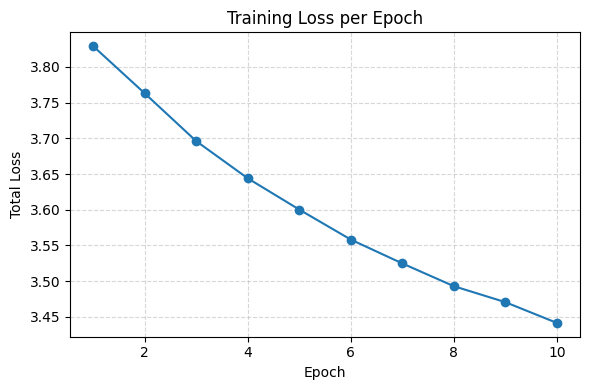

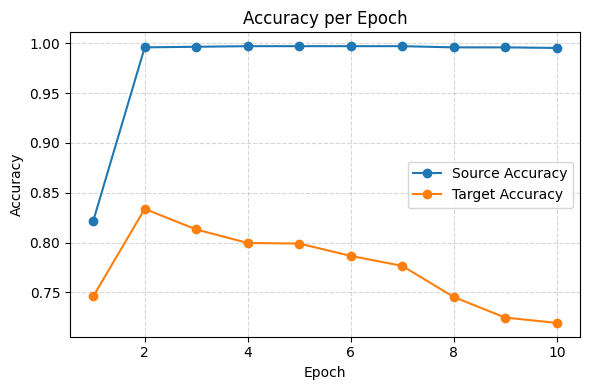

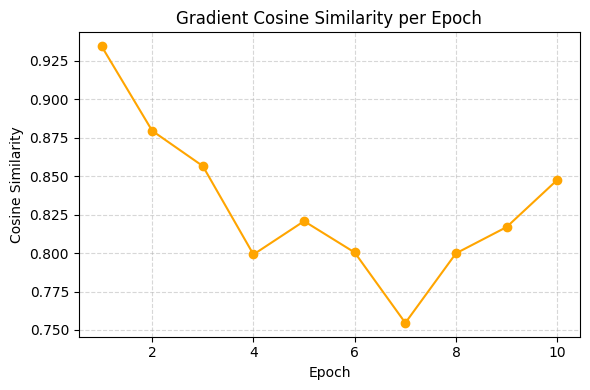

In [ ]:
import json
import matplotlib.pyplot as plt

# --- Load logs ---
with open("training_logs.json", "r") as f:
    logs = json.load(f)

epochs = range(1, len(logs["epoch_loss"]) + 1)

# --- Plot Loss ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["epoch_loss"], marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot Source vs Target Accuracy ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["src_acc"], marker='o', label='Source Accuracy')
plt.plot(epochs, logs["tgt_acc"], marker='o', label='Target Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot Gradient Cosine Similarity ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["grad_conflict"], marker='o', color='orange')
plt.title("Gradient Cosine Similarity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cosine Similarity")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

def get_flat_grads(model, only_ag=True):
    grads = []
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        if only_ag and "dom_ag_ctx" not in name:
            continue  # skip domain-specific grads
        grads.append(p.grad.view(-1))
    return torch.cat(grads) if grads else torch.tensor([], device=device)


# --- Training Settings ---
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=1e-3)

# --- Logging dictionaries ---
logs2 = {
    "epoch_loss": [],
    "src_acc": [],
    "tgt_acc": [],
    "grad_conflict": [],
}

print('-----------------------------------------------------------------')
print(f"Training Learnable Prompts on Source Domains\n")

for epoch in tqdm(range(epochs)):
    epoch_loss = 0.0
    src_correct, tgt_correct = 0, 0
    src_total, tgt_total = 0, 0
    grad_conflicts = []

    for (src_imgs, src_labels), (tgt_imgs, tgt_labels) in zip(source_loader, target_loader):

        optimizer.zero_grad()

        # ----- SOURCE -----
        src_imgs, src_labels = src_imgs.to(device), src_labels.to(device)
        src_img_feats = model.get_image_features(src_imgs)
        src_img_feats = src_img_feats / src_img_feats.norm(dim=-1, keepdim=True)
        src_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, source_domain)
        src_txt_feats = src_txt_feats / src_txt_feats.norm(dim=-1, keepdim=True)
        src_sim = src_img_feats @ src_txt_feats.T
        src_preds = src_sim.argmax(dim=1)
        src_correct += (src_preds == src_labels).sum().item()
        src_total += src_labels.size(0)
        src_loss = loss_fn(src_sim, src_labels)

        src_loss.backward(retain_graph=True)
        src_grd = get_flat_grads(learnable_prompts).detach().clone()

        # ----- TARGET -----
        tgt_imgs, tgt_labels = tgt_imgs.to(device), tgt_labels.to(device)
        tgt_img_feats = model.get_image_features(tgt_imgs)
        tgt_img_feats = tgt_img_feats / tgt_img_feats.norm(dim=-1, keepdim=True)
        tgt_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, target_domain)
        tgt_txt_feats = tgt_txt_feats / tgt_txt_feats.norm(dim=-1, keepdim=True)
        tgt_sim = tgt_img_feats @ tgt_txt_feats.T
        tgt_preds = tgt_sim.argmax(dim=1)
        tgt_correct += (tgt_preds == tgt_labels).sum().item()
        tgt_total += tgt_labels.size(0)
        tgt_loss = loss_fn(tgt_sim, tgt_labels)

        tgt_loss.backward(retain_graph=True)
        tgt_grd = get_flat_grads(learnable_prompts).detach().clone()

        # --- Gradient conflict ---
        if len(src_grd) > 0 and len(tgt_grd) > 0:
            conflict = F.cosine_similarity(src_grd.unsqueeze(0), tgt_grd.unsqueeze(0)).item()
            grad_conflicts.append(conflict)
        else:
            grad_conflicts.append(0.0)

        # --- Total loss & optimization ---
        total_loss = src_loss + tgt_loss
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    # --- Epoch averages ---
    avg_loss = epoch_loss / len(source_loader)
    src_acc = src_correct / src_total if src_total > 0 else 0
    tgt_acc = tgt_correct / tgt_total if tgt_total > 0 else 0
    avg_conflict = sum(grad_conflicts) / len(grad_conflicts)

    # --- Logging ---
    logs2["epoch_loss"].append(avg_loss)
    logs2["src_acc"].append(src_acc)
    logs2["tgt_acc"].append(tgt_acc)
    logs2["grad_conflict"].append(avg_conflict)

    print(f"\nEpoch {epoch+11}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Source Accuracy: {src_acc*100:.2f}%")
    print(f"  Target Accuracy: {tgt_acc*100:.2f}%")
    print(f"  Avg Gradient Cosine Similarity: {avg_conflict:.4f}")

print('\n-----------------------------------------------------------------\n')

# Save logs for later plotting
import json
with open("training_logs2.json", "w") as f:
    json.dump(logs2, f, indent=2)

-----------------------------------------------------------------
Training Learnable Prompts on Source Domains



 10%|█         | 1/10 [01:00<09:08, 60.97s/it]


Epoch 11:
  Total Loss: 3.4275
  Source Accuracy: 99.46%
  Target Accuracy: 70.40%
  Avg Gradient Cosine Similarity: 0.8368


 20%|██        | 2/10 [02:01<08:05, 60.64s/it]


Epoch 12:
  Total Loss: 3.4114
  Source Accuracy: 99.34%
  Target Accuracy: 69.10%
  Avg Gradient Cosine Similarity: 0.8087


 30%|███       | 3/10 [03:01<07:02, 60.31s/it]


Epoch 13:
  Total Loss: 3.3966
  Source Accuracy: 99.34%
  Target Accuracy: 68.40%
  Avg Gradient Cosine Similarity: 0.7998


 40%|████      | 4/10 [04:01<06:02, 60.41s/it]


Epoch 14:
  Total Loss: 3.3888
  Source Accuracy: 99.52%
  Target Accuracy: 68.75%
  Avg Gradient Cosine Similarity: 0.7732


 50%|█████     | 5/10 [05:02<05:01, 60.40s/it]


Epoch 15:
  Total Loss: 3.3813
  Source Accuracy: 99.52%
  Target Accuracy: 69.58%
  Avg Gradient Cosine Similarity: 0.8085


 60%|██████    | 6/10 [06:02<04:01, 60.32s/it]


Epoch 16:
  Total Loss: 3.3674
  Source Accuracy: 99.46%
  Target Accuracy: 70.52%
  Avg Gradient Cosine Similarity: 0.8131


 70%|███████   | 7/10 [07:02<03:00, 60.23s/it]


Epoch 17:
  Total Loss: 3.3629
  Source Accuracy: 99.46%
  Target Accuracy: 71.17%
  Avg Gradient Cosine Similarity: 0.7656


 80%|████████  | 8/10 [08:02<02:00, 60.18s/it]


Epoch 18:
  Total Loss: 3.3538
  Source Accuracy: 99.52%
  Target Accuracy: 68.93%
  Avg Gradient Cosine Similarity: 0.8366


 90%|█████████ | 9/10 [09:02<01:00, 60.15s/it]


Epoch 19:
  Total Loss: 3.3548
  Source Accuracy: 99.58%
  Target Accuracy: 67.75%
  Avg Gradient Cosine Similarity: 0.8179


100%|██████████| 10/10 [10:02<00:00, 60.26s/it]


Epoch 20:
  Total Loss: 3.3385
  Source Accuracy: 99.46%
  Target Accuracy: 69.10%
  Avg Gradient Cosine Similarity: 0.8284

-----------------------------------------------------------------



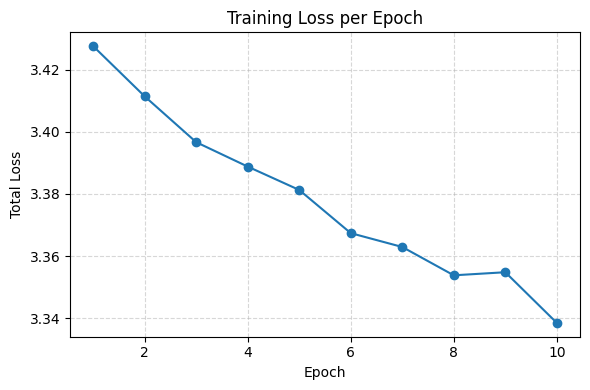

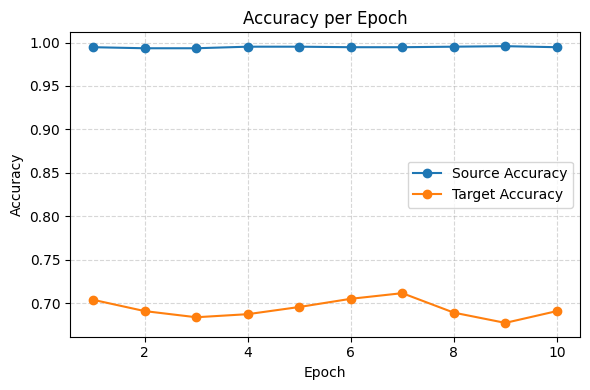

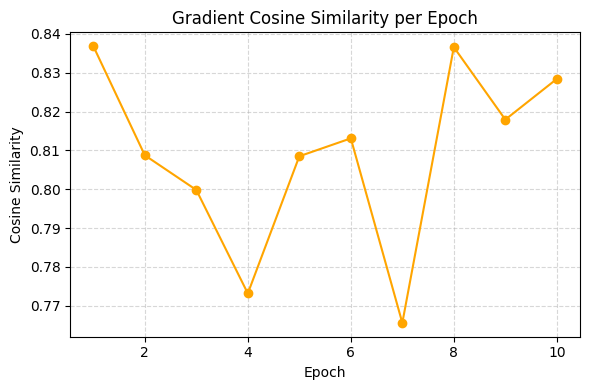

In [ ]:
import json
import matplotlib.pyplot as plt

# --- Load logs ---
with open("training_logs2.json", "r") as f:
    logs = json.load(f)

epochs = range(1, len(logs["epoch_loss"]) + 1)

# --- Plot Loss ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["epoch_loss"], marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot Source vs Target Accuracy ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["src_acc"], marker='o', label='Source Accuracy')
plt.plot(epochs, logs["tgt_acc"], marker='o', label='Target Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot Gradient Cosine Similarity ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["grad_conflict"], marker='o', color='orange')
plt.title("Gradient Cosine Similarity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cosine Similarity")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

def get_flat_grads(model, only_ag=True):
    grads = []
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        if only_ag and "dom_ag_ctx" not in name:
            continue  # skip domain-specific grads
        grads.append(p.grad.view(-1))
    return torch.cat(grads) if grads else torch.tensor([], device=device)


# --- Training Settings ---
epochs = 15
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=1e-3)

# --- Logging dictionaries ---
logs3 = {
    "epoch_loss": [],
    "src_acc": [],
    "tgt_acc": [],
    "grad_conflict": [],
}

print('-----------------------------------------------------------------')
print(f"Training Learnable Prompts on Source Domains With Alignment Loss\n")

for epoch in tqdm(range(epochs)):
    epoch_loss = 0.0
    src_correct, tgt_correct = 0, 0
    src_total, tgt_total = 0, 0
    grad_conflicts = []

    for (src_imgs, src_labels), (tgt_imgs, tgt_labels) in zip(source_loader, target_loader):

        optimizer.zero_grad()

        # ----- SOURCE -----
        src_imgs, src_labels = src_imgs.to(device), src_labels.to(device)
        src_img_feats = model.get_image_features(src_imgs)
        src_img_feats = src_img_feats / src_img_feats.norm(dim=-1, keepdim=True)
        src_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, source_domain)
        src_txt_feats = src_txt_feats / src_txt_feats.norm(dim=-1, keepdim=True)
        src_sim = src_img_feats @ src_txt_feats.T
        src_preds = src_sim.argmax(dim=1)
        src_correct += (src_preds == src_labels).sum().item()
        src_total += src_labels.size(0)
        src_loss = loss_fn(src_sim, src_labels)

        src_loss.backward(retain_graph=True)
        src_grd = get_flat_grads(learnable_prompts).detach().clone()

        # ----- TARGET -----
        tgt_imgs, tgt_labels = tgt_imgs.to(device), tgt_labels.to(device)
        tgt_img_feats = model.get_image_features(tgt_imgs)
        tgt_img_feats = tgt_img_feats / tgt_img_feats.norm(dim=-1, keepdim=True)
        tgt_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, target_domain)
        tgt_txt_feats = tgt_txt_feats / tgt_txt_feats.norm(dim=-1, keepdim=True)
        tgt_sim = tgt_img_feats @ tgt_txt_feats.T
        tgt_preds = tgt_sim.argmax(dim=1)
        tgt_correct += (tgt_preds == tgt_labels).sum().item()
        tgt_total += tgt_labels.size(0)
        tgt_loss = loss_fn(tgt_sim, tgt_labels)

        tgt_loss.backward(retain_graph=True)
        tgt_grd = get_flat_grads(learnable_prompts).detach().clone()

        # --- Gradient conflict ---
        if len(src_grd) > 0 and len(tgt_grd) > 0:
            conflict = F.cosine_similarity(src_grd.unsqueeze(0), tgt_grd.unsqueeze(0)).item()
            grad_conflicts.append(conflict)
        else:
            grad_conflicts.append(0.0)

        # --- Total loss & optimization ---
        align_loss = 1 - F.cosine_similarity(src_grd.unsqueeze(0), tgt_grd.unsqueeze(0)).mean()
        total_loss = src_loss + tgt_loss + 0.01 * align_loss

        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    # --- Epoch averages ---
    avg_loss = epoch_loss / len(source_loader)
    src_acc = src_correct / src_total if src_total > 0 else 0
    tgt_acc = tgt_correct / tgt_total if tgt_total > 0 else 0
    avg_conflict = sum(grad_conflicts) / len(grad_conflicts)

    # --- Logging ---
    logs3["epoch_loss"].append(avg_loss)
    logs3["src_acc"].append(src_acc)
    logs3["tgt_acc"].append(tgt_acc)
    logs3["grad_conflict"].append(avg_conflict)

    print(f"\nEpoch {epoch+11}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Source Accuracy: {src_acc*100:.2f}%")
    print(f"  Target Accuracy: {tgt_acc*100:.2f}%")
    print(f"  Avg Gradient Cosine Similarity: {avg_conflict:.4f}")

print('\n-----------------------------------------------------------------\n')

# Save logs for later plotting
import json
with open("training_logs3.json", "w") as f:
    json.dump(logs3, f, indent=2)

-----------------------------------------------------------------
Training Learnable Prompts on Source Domains With Alignment Loss



  7%|▋         | 1/15 [01:04<15:04, 64.58s/it]


Epoch 11:
  Total Loss: 3.9298
  Source Accuracy: 95.09%
  Target Accuracy: 80.90%
  Avg Gradient Cosine Similarity: 0.8904


 13%|█▎        | 2/15 [02:04<13:27, 62.08s/it]


Epoch 12:
  Total Loss: 3.9254
  Source Accuracy: 99.52%
  Target Accuracy: 85.44%
  Avg Gradient Cosine Similarity: 0.8398


 20%|██        | 3/15 [03:05<12:14, 61.20s/it]


Epoch 13:
  Total Loss: 3.8940
  Source Accuracy: 99.82%
  Target Accuracy: 85.20%
  Avg Gradient Cosine Similarity: 0.8078


 27%|██▋       | 4/15 [04:05<11:08, 60.80s/it]


Epoch 14:
  Total Loss: 3.8487
  Source Accuracy: 99.82%
  Target Accuracy: 81.78%
  Avg Gradient Cosine Similarity: 0.7952


 33%|███▎      | 5/15 [05:05<10:07, 60.76s/it]


Epoch 15:
  Total Loss: 3.8212
  Source Accuracy: 99.82%
  Target Accuracy: 81.78%
  Avg Gradient Cosine Similarity: 0.7761


 40%|████      | 6/15 [06:07<09:10, 61.13s/it]


Epoch 16:
  Total Loss: 3.7992
  Source Accuracy: 99.82%
  Target Accuracy: 81.37%
  Avg Gradient Cosine Similarity: 0.7583


 47%|████▋     | 7/15 [07:08<08:06, 60.84s/it]


Epoch 17:
  Total Loss: 3.7856
  Source Accuracy: 99.76%
  Target Accuracy: 80.84%
  Avg Gradient Cosine Similarity: 0.7413


 53%|█████▎    | 8/15 [08:08<07:04, 60.67s/it]


Epoch 18:
  Total Loss: 3.7559
  Source Accuracy: 99.88%
  Target Accuracy: 78.24%
  Avg Gradient Cosine Similarity: 0.7423


 60%|██████    | 9/15 [09:08<06:03, 60.54s/it]


Epoch 19:
  Total Loss: 3.7644
  Source Accuracy: 99.76%
  Target Accuracy: 76.47%
  Avg Gradient Cosine Similarity: 0.7113


 67%|██████▋   | 10/15 [10:13<05:09, 61.85s/it]


Epoch 20:
  Total Loss: 3.7357
  Source Accuracy: 99.64%
  Target Accuracy: 77.36%
  Avg Gradient Cosine Similarity: 0.7121


 73%|███████▎  | 11/15 [11:19<04:12, 63.02s/it]


Epoch 21:
  Total Loss: 3.7033
  Source Accuracy: 99.58%
  Target Accuracy: 75.83%
  Avg Gradient Cosine Similarity: 0.7262


 80%|████████  | 12/15 [12:27<03:14, 64.69s/it]


Epoch 22:
  Total Loss: 3.7042
  Source Accuracy: 99.52%
  Target Accuracy: 76.18%
  Avg Gradient Cosine Similarity: 0.7055


 87%|████████▋ | 13/15 [13:38<02:13, 66.60s/it]


Epoch 23:
  Total Loss: 3.7082
  Source Accuracy: 99.34%
  Target Accuracy: 76.12%
  Avg Gradient Cosine Similarity: 0.6921


 93%|█████████▎| 14/15 [14:40<01:05, 65.20s/it]


Epoch 24:
  Total Loss: 3.6679
  Source Accuracy: 99.34%
  Target Accuracy: 75.53%
  Avg Gradient Cosine Similarity: 0.7158


100%|██████████| 15/15 [15:41<00:00, 62.77s/it]


Epoch 25:
  Total Loss: 3.6741
  Source Accuracy: 99.16%
  Target Accuracy: 75.65%
  Avg Gradient Cosine Similarity: 0.6995

-----------------------------------------------------------------



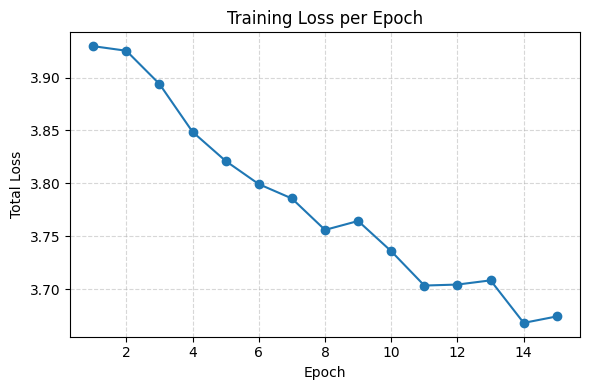

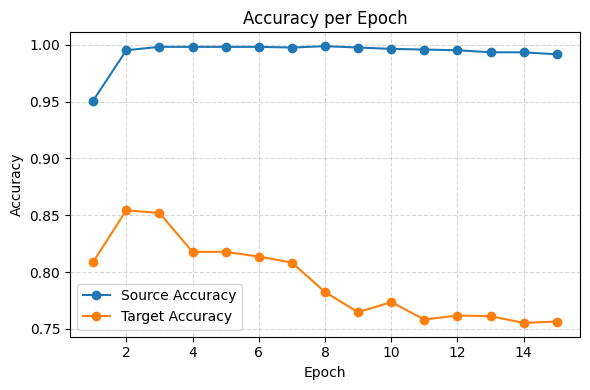

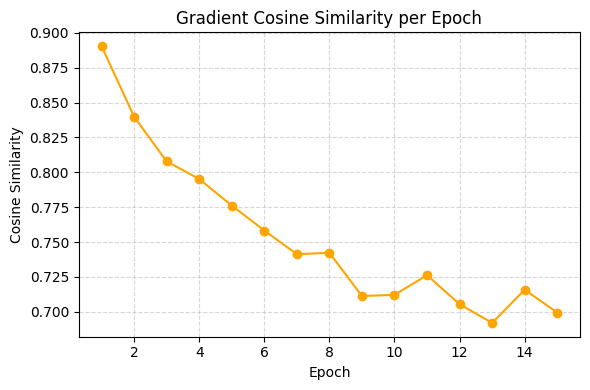

In [ ]:
import json
import matplotlib.pyplot as plt

# --- Load logs ---
with open("training_logs3.json", "r") as f:
    logs = json.load(f)

epochs = range(1, len(logs["epoch_loss"]) + 1)

# --- Plot Loss ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["epoch_loss"], marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot Source vs Target Accuracy ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["src_acc"], marker='o', label='Source Accuracy')
plt.plot(epochs, logs["tgt_acc"], marker='o', label='Target Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Plot Gradient Cosine Similarity ---
plt.figure(figsize=(6, 4))
plt.plot(epochs, logs["grad_conflict"], marker='o', color='orange')
plt.title("Gradient Cosine Similarity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Cosine Similarity")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

def get_grads(model, only_ag=True):
    grads = []
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        if only_ag and "dom_ag_ctx" not in name:
            continue
        grads.append(p.grad.view(-1))
    return torch.cat(grads) if grads else torch.tensor([], device=device)

epochs = 15
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=1e-3)

logs_pcgrad = {"epoch_loss": [], "src_acc": [], "tgt_acc": [], "grad_conflict": []}

print('-----------------------------------------------------------------')
print(f"Training Learnable Prompts on Source Domains with PCGrad\n")

for epoch in tqdm(range(epochs)):
    epoch_loss = 0.0
    src_correct = tgt_correct = src_total = tgt_total = 0
    grad_conflicts = []

    for (src_imgs, src_labels), (tgt_imgs, tgt_labels) in zip(source_loader, target_loader):

        optimizer.zero_grad()

        # --- SOURCE ---
        src_imgs, src_labels = src_imgs.to(device), src_labels.to(device)
        src_img_feats = model.get_image_features(src_imgs)
        src_img_feats = src_img_feats / src_img_feats.norm(dim=-1, keepdim=True)
        src_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, source_domain)
        src_txt_feats = src_txt_feats / src_txt_feats.norm(dim=-1, keepdim=True)
        src_sim = src_img_feats @ src_txt_feats.T
        src_preds = src_sim.argmax(dim=1)
        src_correct += (src_preds == src_labels).sum().item()
        src_total += src_labels.size(0)
        src_loss = loss_fn(src_sim, src_labels)

        src_loss.backward(retain_graph=True)
        src_grads = get_grads(learnable_prompts)

        # --- TARGET ---
        optimizer.zero_grad(set_to_none=True)
        tgt_imgs, tgt_labels = tgt_imgs.to(device), tgt_labels.to(device)
        tgt_img_feats = model.get_image_features(tgt_imgs)
        tgt_img_feats = tgt_img_feats / tgt_img_feats.norm(dim=-1, keepdim=True)
        tgt_txt_feats = create_text_features(model, processor, class_names, learnable_prompts, target_domain)
        tgt_txt_feats = tgt_txt_feats / tgt_txt_feats.norm(dim=-1, keepdim=True)
        tgt_sim = tgt_img_feats @ tgt_txt_feats.T
        tgt_preds = tgt_sim.argmax(dim=1)
        tgt_correct += (tgt_preds == tgt_labels).sum().item()
        tgt_total += tgt_labels.size(0)
        tgt_loss = loss_fn(tgt_sim, tgt_labels)

        tgt_loss.backward(retain_graph=True)
        tgt_grads = get_grads(learnable_prompts)

        # --- PCGRAD Correction ---
        dot = torch.dot(src_grads, tgt_grads)
        if dot < 0:
            tgt_grads = tgt_grads - (dot / (src_grads.norm() ** 2)) * src_grads

        # --- Conflict measure ---
        if len(src_grads) > 0 and len(tgt_grads) > 0:
            conflict = F.cosine_similarity(src_grads.unsqueeze(0), tgt_grads.unsqueeze(0)).item()
            grad_conflicts.append(conflict)
        else:
            grad_conflicts.append(0.0)

        # --- Apply projected gradients manually ---
        optimizer.zero_grad(set_to_none=True)
        total_loss = src_loss + tgt_loss
        total_loss.backward()
        # Replace gradients of domain-agnostic params with projected ones
        idx = 0
        for name, p in learnable_prompts.named_parameters():
            if p.grad is not None and "dom_ag_ctx" in name:
                numel = p.grad.numel()
                p.grad.copy_(tgt_grads[idx: idx + numel].view_as(p.grad))
                idx += numel
        optimizer.step()

        epoch_loss += total_loss.item()

    avg_loss = epoch_loss / len(source_loader)
    src_acc = src_correct / src_total
    tgt_acc = tgt_correct / tgt_total
    avg_conflict = sum(grad_conflicts) / len(grad_conflicts)

    logs_pcgrad["epoch_loss"].append(avg_loss)
    logs_pcgrad["src_acc"].append(src_acc)
    logs_pcgrad["tgt_acc"].append(tgt_acc)
    logs_pcgrad["grad_conflict"].append(avg_conflict)

    print(f"\nEpoch {epoch+1}:")
    print(f"  Total Loss: {avg_loss:.4f}")
    print(f"  Source Acc: {src_acc*100:.2f}% | Target Acc: {tgt_acc*100:.2f}%")
    print(f"  Avg Gradient Cosine Similarity: {avg_conflict:.4f}")

print('\n-----------------------------------------------------------------\n')


-----------------------------------------------------------------
Training Learnable Prompts on Source Domains with PCGrad



  7%|▋         | 1/15 [01:01<14:23, 61.70s/it]


Epoch 1:
  Total Loss: 3.7953
  Source Acc: 99.64% | Target Acc: 80.37%
  Avg Gradient Cosine Similarity: 0.3048


 13%|█▎        | 2/15 [02:01<13:07, 60.57s/it]


Epoch 2:
  Total Loss: 3.7350
  Source Acc: 99.70% | Target Acc: 82.19%
  Avg Gradient Cosine Similarity: 0.3644


 20%|██        | 3/15 [03:02<12:09, 60.81s/it]


Epoch 3:
  Total Loss: 3.6757
  Source Acc: 99.64% | Target Acc: 78.60%
  Avg Gradient Cosine Similarity: 0.2024


 27%|██▋       | 4/15 [04:02<11:05, 60.47s/it]


Epoch 4:
  Total Loss: 3.6240
  Source Acc: 99.64% | Target Acc: 75.83%
  Avg Gradient Cosine Similarity: 0.1109


 33%|███▎      | 5/15 [05:02<10:02, 60.28s/it]


Epoch 5:
  Total Loss: 3.5824
  Source Acc: 99.64% | Target Acc: 75.88%
  Avg Gradient Cosine Similarity: 0.1081


 40%|████      | 6/15 [06:02<09:01, 60.11s/it]


Epoch 6:
  Total Loss: 3.5459
  Source Acc: 99.58% | Target Acc: 76.71%
  Avg Gradient Cosine Similarity: 0.0799


 47%|████▋     | 7/15 [07:02<08:00, 60.07s/it]


Epoch 7:
  Total Loss: 3.5220
  Source Acc: 99.64% | Target Acc: 76.95%
  Avg Gradient Cosine Similarity: 0.0778


# Open Set Experiment

In [ ]:
def open_set_analysis(model, processor, dataloaders, classes, seen_classes, unseen_classes,
                      tuned_prompt_embeds=None, zero_shot_prompt_embeds=None, prompt_model=None,):
    """
    Evaluate open-set performance and prompt similarity metrics.
    """
    label_map = {c: i for i, c in enumerate(seen_classes)}

    # --- Text embeddings for seen classes ---
    prompts = [f"a photo of {c}" for c in seen_classes]
    with torch.inference_mode():
        tokens = processor(text=prompts, return_tensors='pt', padding=True).to(device)
        text_embeds = model.get_text_features(**tokens)
        text_embeds = text_embeds.clone().detach()
        text_embeds /= text_embeds.norm(dim=-1, keepdim=True)

    msp_all, is_seen_all = [], []
    correct, total = 0, 0

    for domain in dataloaders.keys():
        for imgs, labels in tqdm(dataloaders[domain], desc=f"Domain {domain}"):
            imgs = imgs.to(device)
            labels = labels.to(device)

            img_embeds = model.get_image_features(imgs)
            img_embeds = img_embeds.clone().detach()
            img_embeds /= img_embeds.norm(dim=-1, keepdim=True)
            sims = img_embeds @ text_embeds.T
            probs = sims.softmax(dim=-1)

            msp = probs.max(dim=-1)[0]
            msp_all.append(msp.cpu())

            is_seen = torch.tensor([1 if classes[l] in seen_classes else 0 for l in labels])
            is_seen_all.append(is_seen)

            mapped_labels = torch.tensor([
                label_map[classes[l]] if classes[l] in seen_classes else -1 for l in labels
            ])
            preds = sims.argmax(dim=-1)
            mask = mapped_labels != -1
            correct += (preds[mask] == mapped_labels[mask].to(device)).sum().item()
            total += mask.sum().item()

    msp_all = torch.cat(msp_all)
    is_seen_all = torch.cat(is_seen_all)

    # --- Metrics ---
    acc_seen = correct / total if total > 0 else 0
    auroc = roc_auc_score(is_seen_all.numpy(), msp_all.numpy())

    fpr, tpr, thresholds = roc_curve(is_seen_all.numpy(), msp_all.numpy())
    fpr_at_95tpr = np.interp(0.95, tpr, fpr)

    seen_msp = msp_all[is_seen_all == 1]
    unseen_msp = msp_all[is_seen_all == 0]

    print(f"Seen Accuracy: {acc_seen*100:.2f}%")
    print(f"AUROC (open-set): {auroc:.3f}")
    print(f"FPR@95TPR: {fpr_at_95tpr:.3f}")
    print(f"MSP (Seen mean ± std): {seen_msp.mean():.3f} ± {seen_msp.std():.3f}")
    print(f"MSP (Unseen mean ± std): {unseen_msp.mean():.3f} ± {unseen_msp.std():.3f}")

    # --- Prompt metrics (if provided) ---
    if tuned_prompt_embeds is not None and zero_shot_prompt_embeds is not None:
        sim = F.cosine_similarity(
            tuned_prompt_embeds.mean(dim=0, keepdim=True),
            zero_shot_prompt_embeds.mean(dim=0, keepdim=True)
        )
        print(f"Cosine similarity (tuned vs zero-shot prompt): {sim.item():.3f}")

    return {
        "acc_seen": acc_seen,
        "auroc": auroc,
        "fpr95": fpr_at_95tpr,
        "seen_msp_mean": seen_msp.mean().item(),
        "unseen_msp_mean": unseen_msp.mean().item()
    }

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
unseen_classes = ['dog', 'person']
seen_classes = [c for c in classes if c not in unseen_classes]

open_set_analysis(model, processor, dataloaders, classes, seen_classes, unseen_classes)

Domain sketch: 100%|██████████| 123/123 [00:18<00:00,  6.57it/s]

Seen Accuracy: 94.37%
AUROC (open-set): 0.962
FPR@95TPR: 0.220
MSP (Seen mean ± std): 0.213 ± 0.003
MSP (Unseen mean ± std): 0.204 ± 0.002


{'acc_seen': 0.9436619718309859,
 'auroc': np.float64(0.9623817742412479),
 'fpr95': np.float64(0.22015748031496063),
 'seen_msp_mean': 0.21263356506824493,
 'unseen_msp_mean': 0.20436470210552216}

In [ ]:
class LearnablePrompts(nn.Module):
  def __init__(self, domains, dom_ag=10, dom_sp=10, ctx_dim=512):
    super().__init__()
    self.dom_ag_ctx = nn.Parameter(torch.randn(dom_ag, ctx_dim), requires_grad=True)
    self.dom_sp_ctx = nn.ParameterDict({
          d: nn.Parameter(torch.randn(dom_sp, ctx_dim), requires_grad=True)
          for d in domains
        })
  def get_ctx(self, domain):
    return torch.cat([self.dom_ag_ctx, self.dom_sp_ctx[domain]], dim=0)


def create_text_features(clip_model, processor, classnames, learnable_prompts, domain, device="cuda", batch_size=16):
    clip_model.eval()
    all_text_features = []

    for i in range(0, len(classnames), batch_size):
        batch_classes = classnames[i:i + batch_size]
        ctx = learnable_prompts.get_ctx(domain)  # (n_ctx, ctx_dim)
        n_ctx = ctx.size(0)
        num_classes = len(batch_classes)

        # --- Tokenize batch ---
        tokens = processor(text=batch_classes, return_tensors="pt", padding=True, truncation=True).to(device)
        token_embeds = clip_model.text_model.embeddings.token_embedding(tokens.input_ids)

        # --- Insert learnable prompts after SOS ---
        sos = token_embeds[:, :1, :]
        rest = token_embeds[:, 1:, :]
        prompt_ctx = ctx.unsqueeze(0).expand(num_classes, -1, -1)
        new_embeds = torch.cat([sos, prompt_ctx, rest], dim=1)

        # --- Add positional embeddings ---
        pos_embeds = clip_model.text_model.embeddings.position_embedding(
            torch.arange(new_embeds.size(1), device=device).unsqueeze(0)
        )
        final_embeds = new_embeds + pos_embeds

        # --- Attention mask ---
        prompt_mask = torch.ones((num_classes, n_ctx), dtype=torch.bool, device=device)
        attention_mask = torch.cat(
            [tokens.attention_mask[:, :1].bool(), prompt_mask, tokens.attention_mask[:, 1:].bool()],
            dim=1
        )
        attention_mask = attention_mask[:, None, None, :]

        # --- Encoder forward ---
        encoder_out = clip_model.text_model.encoder(inputs_embeds=final_embeds, attention_mask=attention_mask)
        hidden = encoder_out.last_hidden_state
        hidden = clip_model.text_model.final_layer_norm(hidden)

        # --- EOS-based pooling ---
        eos_idx = attention_mask.squeeze().sum(dim=1) - 1
        text_embeds = hidden[torch.arange(num_classes, device=device), eos_idx]
        text_features = clip_model.text_projection(text_embeds)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # --- Store on CPU to free VRAM ---
        all_text_features.append(text_features.cpu())
        torch.cuda.empty_cache()

    return torch.cat(all_text_features, dim=0)


In [ ]:
def train_prompts_on_seen_classes(
    clip_model, processor, dataloaders, learnable_prompts,
    classes, seen_classes, epochs=5, device="cuda", reg_lambda=0.0
):
    clip_model.eval()                     # CLIP stays frozen
    learnable_prompts.train()             # Train only prompts
    optimizer = torch.optim.Adam(learnable_prompts.parameters(), lr=5e-3)

    # Map global class names to local (seen-only) indices
    class_to_local_idx = {cls: i for i, cls in enumerate(seen_classes)}
    global_to_local_idx = {i: class_to_local_idx[c] for i, c in enumerate(classes) if c in seen_classes}
    seen_global_indices = list(global_to_local_idx.keys())


    for epoch in range(epochs):
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        total_batches = 0

        for domain, loader in dataloaders.items():

            for imgs, labels in tqdm(loader, desc=f"Epoch {epoch+1}, Domain {domain}", leave=False):

                # --- FIX: Generate text features INSIDE the batch loop ---
                # A fresh graph is created here for every batch.
                text_features = create_text_features(clip_model, processor, seen_classes, learnable_prompts, domain)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                text_features = text_features.to(device)
                # --------------------------------------------------------

                imgs, labels = imgs.to(device), labels.to(device) # Labels are global indices (0 to N-1)

                # Filter for seen classes only
                mask = torch.isin(labels, torch.tensor(seen_global_indices, device=device))
                if mask.sum() == 0:
                    continue

                imgs_seen = imgs[mask]
                labels_global_seen = labels[mask].cpu().numpy()

                # Convert global labels to local (seen-only) labels (0 to M-1)
                labels_local_seen = torch.tensor([
                    global_to_local_idx[l] for l in labels_global_seen
                ], device=device)

                with torch.no_grad():
                    image_features = clip_model.get_image_features(imgs_seen)
                    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

                # Logits computed against ONLY seen classes
                logits = 100.0 * image_features @ text_features.T
                loss = F.cross_entropy(logits, labels_local_seen)

                optimizer.zero_grad()
                loss.backward() # Consumes the graph built with text_features
                optimizer.step()

                # Accuracy
                preds = logits.argmax(dim=-1)
                correct = (preds == labels_local_seen).sum().item()
                total_correct += correct
                total_samples += len(labels_local_seen)
                total_loss += loss.item()
                total_batches += 1

        avg_loss = total_loss / max(total_batches, 1)
        acc = total_correct / max(total_samples, 1)

        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Seen Accuracy: {acc*100:.2f}%")

    print("✅ Prompt tuning on seen classes complete.")

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
unseen_classes = ['dog', 'person']
seen_classes = [c for c in classes if c not in unseen_classes]

learnable_prompts = LearnablePrompts(dataloaders.keys()).to(device)
train_prompts_on_seen_classes(model, processor, dataloaders, learnable_prompts, classes, seen_classes)

Epoch 1/5 | Avg Loss: 0.1001 | Seen Accuracy: 96.90%


Epoch 2/5 | Avg Loss: 0.1078 | Seen Accuracy: 95.76%


Epoch 3/5 | Avg Loss: 0.1132 | Seen Accuracy: 95.53%


Epoch 4/5 | Avg Loss: 0.1004 | Seen Accuracy: 96.04%


Epoch 5/5 | Avg Loss: 0.0873 | Seen Accuracy: 96.74%
✅ Prompt tuning on seen classes complete.


In [ ]:
def open_set_analysis_learnable(clip_model, processor, dataloaders, classes,
                                seen_classes, unseen_classes,
                                prompt_model=None, tuned_prompt_embeds=None, zero_shot_prompt_embeds=None,
                                device="cuda"):

    # Map classes to indices
    # Global map (all classes: 0 to N-1)
    class_to_global_idx = {cls: i for i, cls in enumerate(classes)}
    # Local map (seen classes: 0 to M-1)
    class_to_local_idx = {cls: i for i, cls in enumerate(seen_classes)}

    # Indices of seen classes within the global 'classes' list
    seen_indices_in_global = torch.tensor([
        class_to_global_idx[c] for c in seen_classes
    ], device=device)

    msp_all, is_seen_all = [], []
    correct, total = 0, 0
    avg_cos_sim = None # Initialize for prompt similarity

    clip_model.eval()
    if prompt_model is not None:
        prompt_model.eval()

    with torch.inference_mode():
      for domain in dataloaders.keys():
        print(f"\n Evaluating domain: {domain}")

        # --- Text embeddings from learnable prompts ---
        # Logits computed against ALL classes (seen + unseen) for open-set detection
        text_embeds = create_text_features(clip_model, processor, classes, prompt_model, domain)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds.to(device)

        for imgs, labels in tqdm(dataloaders[domain], desc=f"Domain {domain}", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device) # Labels are global indices (0 to N-1)

            # --- Image embeddings ---
            img_embeds = clip_model.get_image_features(imgs)
            img_embeds = img_embeds / img_embeds.norm(dim=-1, keepdim=True)

            # --- Similarity and probabilities (Open-Set Metrics) ---
            # sims is N_batch x N_classes (used for MSP)
            sims = 100.0 * img_embeds @ text_embeds.T
            probs = sims.softmax(dim=-1)
            msp = probs.max(dim=-1)[0] # Maximum Softmax Probability

            msp_all.append(msp.cpu())

            # --- Identify seen/unseen samples ---
            is_seen = torch.tensor([1 if classes[l] in seen_classes else 0 for l in labels.cpu()])
            is_seen_all.append(is_seen)

            # --- Classification Accuracy for Seen Samples (FIXED) ---
            mask_seen = is_seen.to(device).bool() # Boolean mask for seen images

            if mask_seen.sum() > 0:
                # 1. Filter logits to include ONLY seen classes
                sims_seen_only = sims[mask_seen][:, seen_indices_in_global]

                # 2. Get local index prediction (0 to M-1)
                preds_seen_only = sims_seen_only.argmax(dim=-1)

                # 3. Map the global label to the local index (0 to M-1)
                # We only consider labels that correspond to seen images (using mask_seen)
                global_labels_seen = labels[mask_seen].cpu().numpy()
                mapped_labels_seen = torch.tensor([
                    class_to_local_idx[classes[l]] for l in global_labels_seen
                ], device=device)

                # 4. Compare local prediction with local label
                correct += (preds_seen_only == mapped_labels_seen).sum().item()
                total += mask_seen.sum().item()

    # --- Combine all domains ---
    msp_all = torch.cat(msp_all)
    is_seen_all = torch.cat(is_seen_all)

    # --- Compute metrics ---
    acc_seen = correct / total if total > 0 else 0
    # AUROC requires scores for the positive class (Seen=1)
    # Since higher MSP should indicate "Seen", we use MSP directly.
    auroc = roc_auc_score(is_seen_all.numpy(), msp_all.numpy())

    fpr, tpr, thresholds = roc_curve(is_seen_all.numpy(), msp_all.numpy())
    # Note: np.interp requires sorted arrays. roc_curve sorts them.
    fpr_at_95tpr = np.interp(0.95, tpr, fpr)

    seen_msp = msp_all[is_seen_all == 1]
    unseen_msp = msp_all[is_seen_all == 0]

    print("\n📊 **Open-Set Metrics**")
    print(f"Seen Accuracy: {acc_seen*100:.2f}%")
    print(f"AUROC (open-set, MSP score): {auroc:.3f}")
    print(f"FPR@95TPR: {fpr_at_95tpr:.3f}")
    print(f"MSP (Seen mean ± std): {seen_msp.mean():.3f} ± {seen_msp.std():.3f}")
    print(f"MSP (Unseen mean ± std): {unseen_msp.mean():.3f} ± {unseen_msp.std():.3f}")

    # --- Inter-prompt cosine similarity (FIXED) ---
    if prompt_model is not None:
        with torch.no_grad():
            prompt_embeds = []
            domains_list = list(prompt_model.dom_sp_ctx.keys())

            for domain in domains_list:
                # Get the full context (dom_ag_ctx + dom_sp_ctx[domain])
                ctx = prompt_model.get_ctx(domain)
                # Flatten the context vector for similarity comparison
                prompt_embeds.append(ctx.flatten())

            prompt_embeds = torch.stack(prompt_embeds, dim=0).to(device) # (N_domains, flattened_dim)

            # Calculate pairwise cosine similarity
            sim_matrix = F.cosine_similarity(
                prompt_embeds.unsqueeze(1), prompt_embeds.unsqueeze(0), dim=-1
            )

            # The diagonal is 1.0 (prompt vs itself), so we exclude it for the mean
            num_domains = prompt_embeds.size(0)
            off_diag_mask = ~torch.eye(num_domains, dtype=torch.bool, device=device)

            # Calculate the mean of all OFF-diagonal elements
            avg_cos_sim = sim_matrix[off_diag_mask].mean().item()

            print(f"🔸 Average cosine similarity between learned full prompts across domains: {avg_cos_sim:.3f}")

    return {
        "acc_seen": acc_seen,
        "auroc": auroc,
        "fpr95": fpr_at_95tpr,
        "seen_msp_mean": seen_msp.mean().item(),
        "unseen_msp_mean": unseen_msp.mean().item(),
        "avg_prompt_cosine": avg_cos_sim
    }

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


metrics = open_set_analysis_learnable(model, processor, dataloaders, classes, seen_classes, unseen_classes, learnable_prompts)


 Evaluating domain: art_painting



 Evaluating domain: cartoon



 Evaluating domain: photo



 Evaluating domain: sketch



📊 **Open-Set Metrics**
Seen Accuracy: 97.49%
AUROC (open-set, MSP score): 0.872
FPR@95TPR: 0.854
MSP (Seen mean ± std): 0.965 ± 0.102
MSP (Unseen mean ± std): 0.883 ± 0.148
🔸 Average cosine similarity between learned full prompts across domains: 0.513
